# Functions for importing data

In [1]:
import numpy as np
import scipy as sp
import h5py as hp
import matplotlib.pyplot as plt
import copy

def lengthscale_SI(unitscaling):
    """Returns the lengthscale from a Damysos.UnitScaling object in meters

    Args:
        unitscaling (dict): loaded dict from .hdf5 of Damysos

    Returns:
        float: lengthscale in meter
    """
    # UnitScaling{T} uses nanometers
    return unitscaling['lengthscale'] * sp.constants.nano

def timescale_SI(unitscaling):
    """Returns the timescale from a Damysos.UnitScaling object in meters

    Args:
        unitscaling (dict): loaded dict from .hdf5 of Damysos

    Returns:
        float: timescale in seconds
    """
    # UnitScaling{T} uses femtoseconds
    return unitscaling['timescale'] * sp.constants.femto


def velocity_SI(simulation):
    """Returns the velocity density from a Damysos.Simulation object SI units

    Args:
        simulation (dict): loaded dict from .hdf5 of Damysos

    Returns:
        dict: velocity in SI units
    """
    sim = copy.deepcopy(simulation)
    tc = timescale_SI(sim['unitscaling'])
    lc = lengthscale_SI(sim['unitscaling'])
    d  = sim['dim']
    
    v                   = copy.deepcopy(sim['observables']['velocity'])
    v_SI                = {}
    velocity_components = ['vx','vxintra', 'vxinter']
    si_factor           = lc**(1-d) / tc
    
    if d==2:
        velocity_components.extend(['vy', 'vyintra', 'vyinter'])
        
    for k in velocity_components:
        v_SI[k] = v[k] * si_factor
        
    return v_SI

def velocity_au(simulation):
    """Returns the velocity density from a Damysos.Simulation object atomic units

    Args:
        simulation (dict): loaded dict from .hdf5 of Damysos

    Returns:
        dict: velocity in atomic units
    """
    v_SI        = velocity_SI(simulation)
    d           = int(simulation['dim'])
    lc          = sp.constants.physical_constants['atomic unit of length'][0]
    tc          = sp.constants.physical_constants['atomic unit of time'][0]
    au_factor   = lc**(d-1) * tc
    
    v_au = {}
    
    for k,v in v_SI.items():
        v_au[k] = au_factor * v
    return v_au

def current_density_SI(simulation):
    """Returns the current density from a Damysos.Simulation object in SI units

    Args:
        simulation (dict): loaded dict from .hdf5 generated by Damysos
        
    Returns:
        dict: current density in SI units
    """
    v = velocity_SI(simulation)
    si_charge = sp.constants.elementary_charge
    current_density = {}
    
    for k,v in v.items():
        current_density[k.replace('v','j')] = v * si_charge
        
    return current_density

def current_density_au(simulation):
    """Current density from a Damysos.Simulation object in atomic units

    Args:
        simulation (dict): loaded dict from .hdf5 of Damysos

    Returns:
        dict: current in atomic units
    """
    v_au      = velocity_au(simulation)
    j         = {}
    
    for k,v in v_au.items():
        j[k.replace('v','j')] = v # e = 1 in atomic units
    return j


def gettsamples_SI(simulation):
    tc = timescale_SI(simulation['unitscaling'])
    return simulation['numericalparams']['tsamples'] * tc

def gettsamples_au(simulation):
    ts_SI = gettsamples_SI(simulation)
    return ts_SI / sp.constants.physical_constants['atomic unit of time'][0]
        

In [2]:
def peak_field_strength_SI(simulation):
    """
        Peak field strength from a Damysos.Simulation object in SI units
    Args:
        simulation (dict): loaded dict from .hdf5 of Damysos
        
    Returns:
        float: maximum electric field strength in V/m
    """
    
    tc      = timescale_SI(simulation['unitscaling'])
    lc      = lengthscale_SI(simulation['unitscaling'])
    e       = sp.constants.elementary_charge
    hbar    = sp.constants.hbar
    return simulation['drivingfield']['eE'] * hbar / (e*tc*lc)

def angular_frequency_SI(simulation):
    """
        Central (angular) driving frequency from a Damysos.Simulation object in SI units
    Args:
        simulation (dict): loaded dict from .hdf5 of Damysos
        
    Returns:
        float: angular driving frequency in 1/s
    """
    return simulation['drivingfield']['ω'] / timescale_SI(simulation['unitscaling'])

In [3]:
import os
import h5py

def find_hdf5_files(directory):
    """
    Recursively finds all .hdf5 files in a given directory and its subdirectories.
    
    Args:
        directory (str): The root directory to search for .hdf5 files.

    Returns:
        list: A list of paths to .hdf5 files.
    """
    hdf5_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.hdf5'):
                hdf5_files.append(os.path.join(root, file))
    return hdf5_files

def load_hdf5_data(file_path):
    """
    Loads data from an .hdf5 file.
    
    Args:
        file_path (str): Path to the .hdf5 file.

    Returns:
        dict: A dictionary containing the data and groups from the file.
    """
    data = {}
    try:
        with h5py.File(file_path, 'r') as f:
            def recursively_load(h5group, container):
                for key, item in h5group.items():
                    if isinstance(item, h5py.Dataset):
                        container[key] = item[()]
                    elif isinstance(item, h5py.Group):
                        container[key] = {}
                        recursively_load(item, container[key])
            recursively_load(f, data)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    return data

def load_hdf5_files(directory):
    """
    Main function to search for .hdf5 files in a directory and load their data.

    Args:
        directory (str): The directory to search for .hdf5 files.
    """
    hdf5_files = find_hdf5_files(directory)
    print(f"Found {len(hdf5_files)} .hdf5 files.")

    return [load_hdf5_data(f) for f in hdf5_files]


In [4]:
import re

def format_string(input_string):
    # Use regex to extract M and zeta values
    match = re.search(r"M=([\d.]+)_zeta=([\d.]+)", input_string)
    if not match:
        return "Invalid input string"
    
    # Extract the values
    m_value, zeta_value = match.groups()
    
    # Format and return the result
    return f"ζ = {zeta_value} M = {m_value}"

# Example usage
input_string = 'M=0.1_zeta=0.1_final1d_1e-2'
formatted_string = format_string(input_string)
print(formatted_string)  # Output: ζ = 0.1 M = 0.1


ζ = 0.1 M = 0.1


# Intensity spectra for CS paper

## Functions for calculating spectra & plotting

In [5]:
def spectrum(simulation, 
    maxharm=40, zero_padding_factor = 5, title = ""):
    
    """
    Computes and plots the spectrum of the given Damysos simulation.

    Parameters:
        simulation (dict): Damysos.Simulation loaded from .hdf5 as dict
    
    Keyword arguments:
        maxharm (int): Maximum harmonic number plotted
        zero_padding_factor (int): Padding factor
        title (string): title of figure

    Returns:
        matplotlib.figure.Figure: The figure containing the plot.
    """
    
    # Create the figure
    fig = plt.figure(figsize=(10, 6))
    ax  = fig.add_subplot(1, 1, 1)

    return spectrum_ax(simulation,ax,maxharm=maxharm,zero_padding_factor=zero_padding_factor,
                    title=title)

def spectrum_ax(simulation,axes,
    maxharm=40, 
    zero_padding_factor = 5, 
    title = "", 
    xlabel = r"Frequency $\frac{\omega}{\omega_0}$",
    ylabel = r"Intensity $I(\omega)$ [atomic units]",
    ylim = None):
    
    """
    Computes and plots the spectrum of the given Damysos simulation and plots it into axis.

    Parameters:
        simulation (dict): Damysos.Simulation loaded from .hdf5 as dict
        axes (matplotlib.axes._axes.Axes): axes to plot into
    
    Keyword arguments:
        maxharm (int): Maximum harmonic number plotted
        zero_padding_factor (int): Padding factor
        title (string): title of figure
        ylim (tuple): y-limits of axes

    Returns:
        None
    """
    emission_intensity_au = intensity_au(simulation,zero_padding_factor)
    positive_freqs        = emission_intensity_au["freqs"]
    
    for label,data in emission_intensity_au.items():
        if label == 'freqs' or label == 'freqs_au':
            continue
        
        axes.plot(positive_freqs, data, label=label)
        axes.set_xlim(0, maxharm)
        
        if label == "total":            
            if ylim != None:
                axes.set_ylim(ylim)
            y0,_ = axes.get_ylim()
            axes.fill_between(positive_freqs,y0,data,color="C0")
        
        axes.set_yscale("log")
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_title(title)
        axes.grid(True, which="both", alpha=0.3)

def intensity_au(simulation, zero_padding_factor = 5, window = np.hanning):
    
    j_au            = current_density_au(simulation)
    sampling_rate   = 1/simulation['numericalparams']['dt']
        
    c_SI    = sp.constants.speed_of_light
    t0_au   = sp.constants.physical_constants["atomic unit of time"][0]
    l0_au   = sp.constants.physical_constants["atomic unit of length"][0]
    c_au    = c_SI * t0_au / l0_au # ~ 137 au
    
    intensity = {}
    
    for data,label in zip([j_au['jx'],j_au["jxintra"],j_au['jxinter']],
                          ["total", "intra", "inter"]):
    
        n_padded            = zero_padding_factor*len(data)
        positive_fft_values,positive_freqs = real_fourier_trafo(data,sampling_rate,n_padded)
        positive_freqs_au   = positive_freqs * t0_au / timescale_SI(simulation['unitscaling'])    
        magnitude           = np.abs(positive_fft_values) ** 2
        intensity[label]    = 4*np.pi**2 * positive_freqs_au**2 * magnitude / (3*c_au**3)
        intensity["freqs_au"]   = positive_freqs_au
        intensity["freqs"]      = positive_freqs
        
    return intensity

def real_fourier_trafo(data,sampling_rate,n_pad=50,window=np.hanning):
    # Apply a  window
    windowed_data   = data * window(len(data))
    
    # Zero padding
    n_original  = len(windowed_data)
    n_padded    = n_original + n_pad
    padded_data = np.pad(windowed_data, (0, n_padded - n_original), mode='constant')
    

    # Compute the Fourier Transform
    fft_values = np.fft.fft(padded_data)
    freqs = np.fft.fftfreq(n_padded, d=1/sampling_rate)

    # Only take the positive half of the spectrum (real-valued input implies symmetry)
    positive_freqs = freqs[:n_padded // 2]

    # Compute the magnitude of the Fourier Transform & emission intensity in au
    positive_fft_values = fft_values[:n_padded // 2]  
    
    return positive_fft_values,positive_freqs

## Check for 1D data

In [6]:
path1d = '/home/how09898/phd/data/dirac/zeta-M-sweep1/3x3_final1d_1e-2'
data1d = load_hdf5_files(path1d)

Found 9 .hdf5 files.


In [7]:
for d in data1d:
    print(format_string(d['id'].decode('UTF-8')))

ζ = 0.1 M = 0.1
ζ = 0.1 M = 1.0
ζ = 0.1 M = 10.0
ζ = 1.0 M = 0.1
ζ = 1.0 M = 1.0
ζ = 1.0 M = 10.0
ζ = 10.0 M = 0.1
ζ = 10.0 M = 1.0
ζ = 10.0 M = 10.0


In [8]:
newlist = np.matrix(data1d).reshape((3,3)).flat
for d in newlist:
    print(format_string(d['id'].decode('UTF-8')))

ζ = 0.1 M = 0.1
ζ = 0.1 M = 1.0
ζ = 0.1 M = 10.0
ζ = 1.0 M = 0.1
ζ = 1.0 M = 1.0
ζ = 1.0 M = 10.0
ζ = 10.0 M = 0.1
ζ = 10.0 M = 1.0
ζ = 10.0 M = 10.0


In [9]:
em_int = intensity_au(data1d[0])

In [10]:
em_int

{'total': array([0.00000000e+00, 2.73729358e-34, 3.85323621e-33, ...,
        1.20964593e-46, 7.06104967e-47, 2.05921676e-47]),
 'freqs_au': array([0.00000000e+00, 1.34362214e-06, 2.68724429e-06, ...,
        2.14039008e-02, 2.14052444e-02, 2.14065880e-02]),
 'freqs': array([0.00000000e+00, 1.11094369e-02, 2.22188739e-02, ...,
        1.76973330e+02, 1.76984440e+02, 1.76995549e+02]),
 'intra': array([0.00000000e+00, 8.39910814e-36, 2.15906300e-35, ...,
        1.45570835e-46, 9.69359974e-47, 7.58924261e-47]),
 'inter': array([0.00000000e+00, 2.15818935e-34, 3.35265271e-33, ...,
        1.54803106e-47, 2.58049303e-47, 8.32257117e-48])}

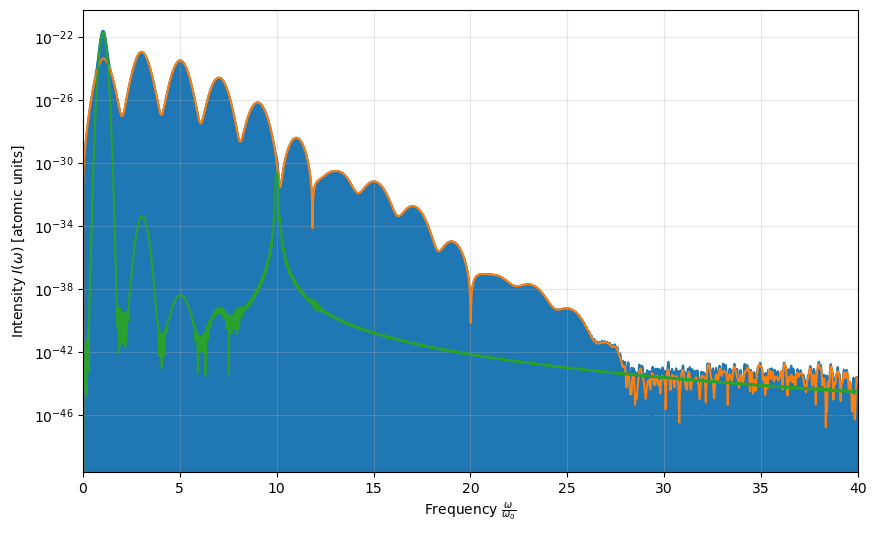

In [11]:
spec=spectrum(data1d[2])

## 3x3 Spectra 2D

Found 9 .hdf5 files.


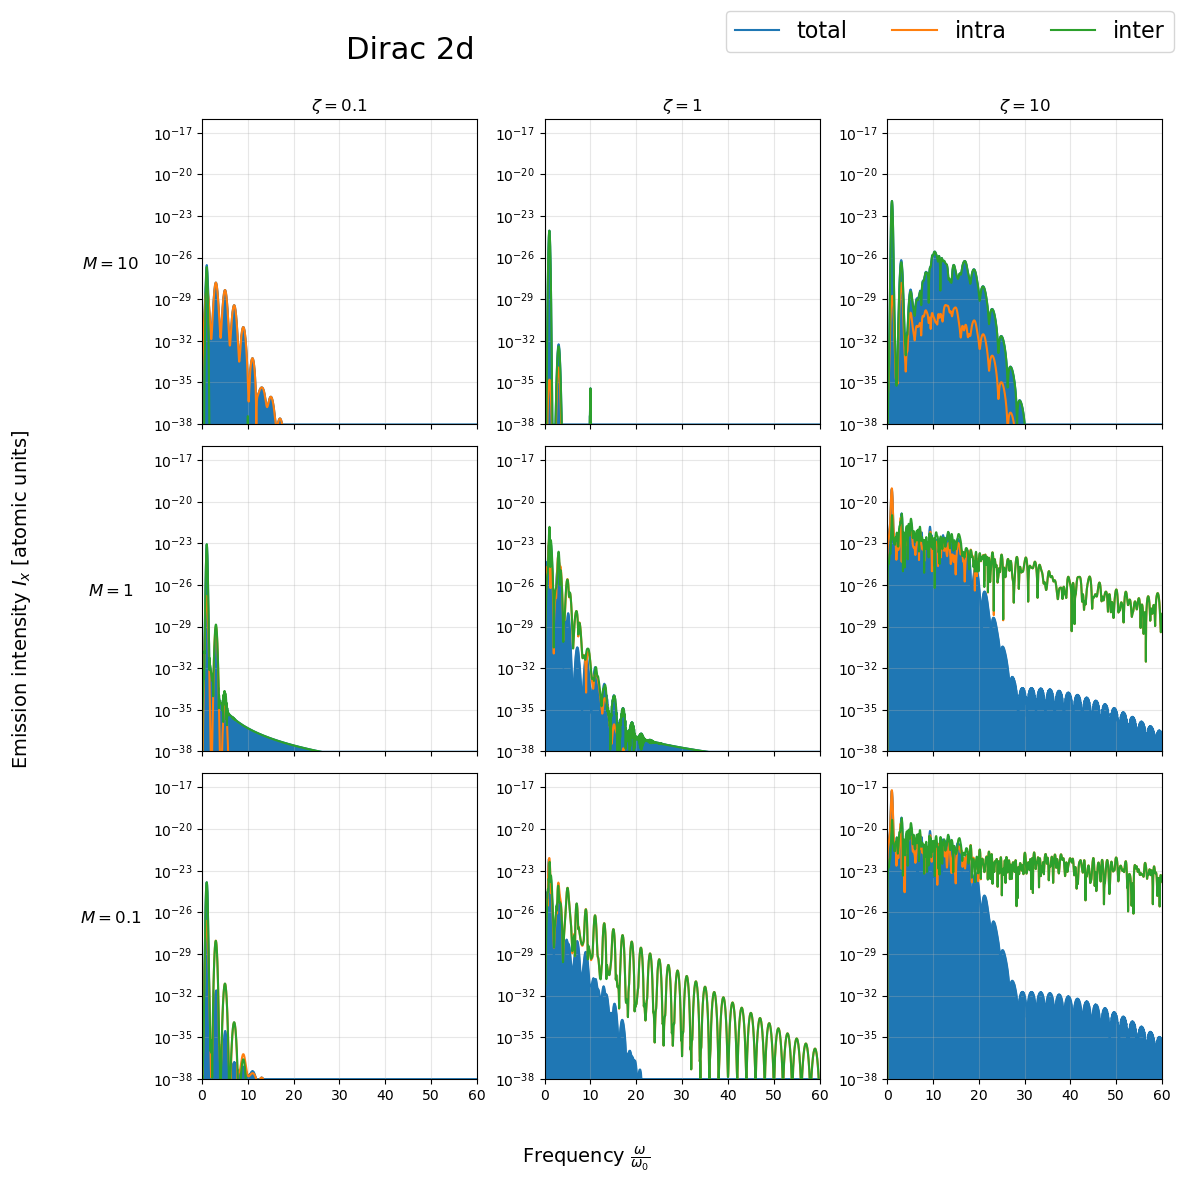

In [12]:
import matplotlib.pyplot as plt
import numpy as np

path2d = '/home/how09898/phd/data/dirac/zeta-M-sweep1/3x3_final2d_1e-2'
data = load_hdf5_files(path2d)

# transpose & flip data
dat = np.flip(np.matrix(data).reshape((3,3)).transpose(),axis=0).flat

# Create a 3x3 grid layout for subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=False)

col_titles = [r"$\zeta = 0.1$",r"$\zeta = 1$",r"$\zeta = 10$"]
row_titles = [r"$M = 10$",r"$M = 1$",r"$M = 0.1$"]

ylim = (1e-38,1e-16)

# Plot the time-series in each subplot
for i, ax in enumerate(axes.flat):
    spectrum_ax(dat[i],ax,xlabel="",ylabel="",ylim=ylim,maxharm=60)
    
for ax, col in zip(axes[0], col_titles):
    ax.set_title(col)
    
for ax, row in zip(axes[:,0], row_titles):
    ax.set_ylabel(row, rotation=0,size='large',labelpad=30)

# Adjust layout to make space for the shared legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Create a shared legend outside the plots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=3, fontsize=16)

# Add labels to the shared axes
fig.text(0.5, 0.03, r"Frequency $\frac{\omega}{\omega_0}$", ha="center", fontsize=14)
fig.text(0.02, 0.5, r"Emission intensity $I_x$ [atomic units]", va="center", rotation="vertical", fontsize=14)
fig.text(0.3,0.95,"Dirac 2d", fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.9,bottom=0.1,left=0.18)

fig.savefig(fname="3x3_spectra_2d.png", dpi=300)

# Show the plot
plt.show()


## 3x3 Spectra 1D

Found 9 .hdf5 files.


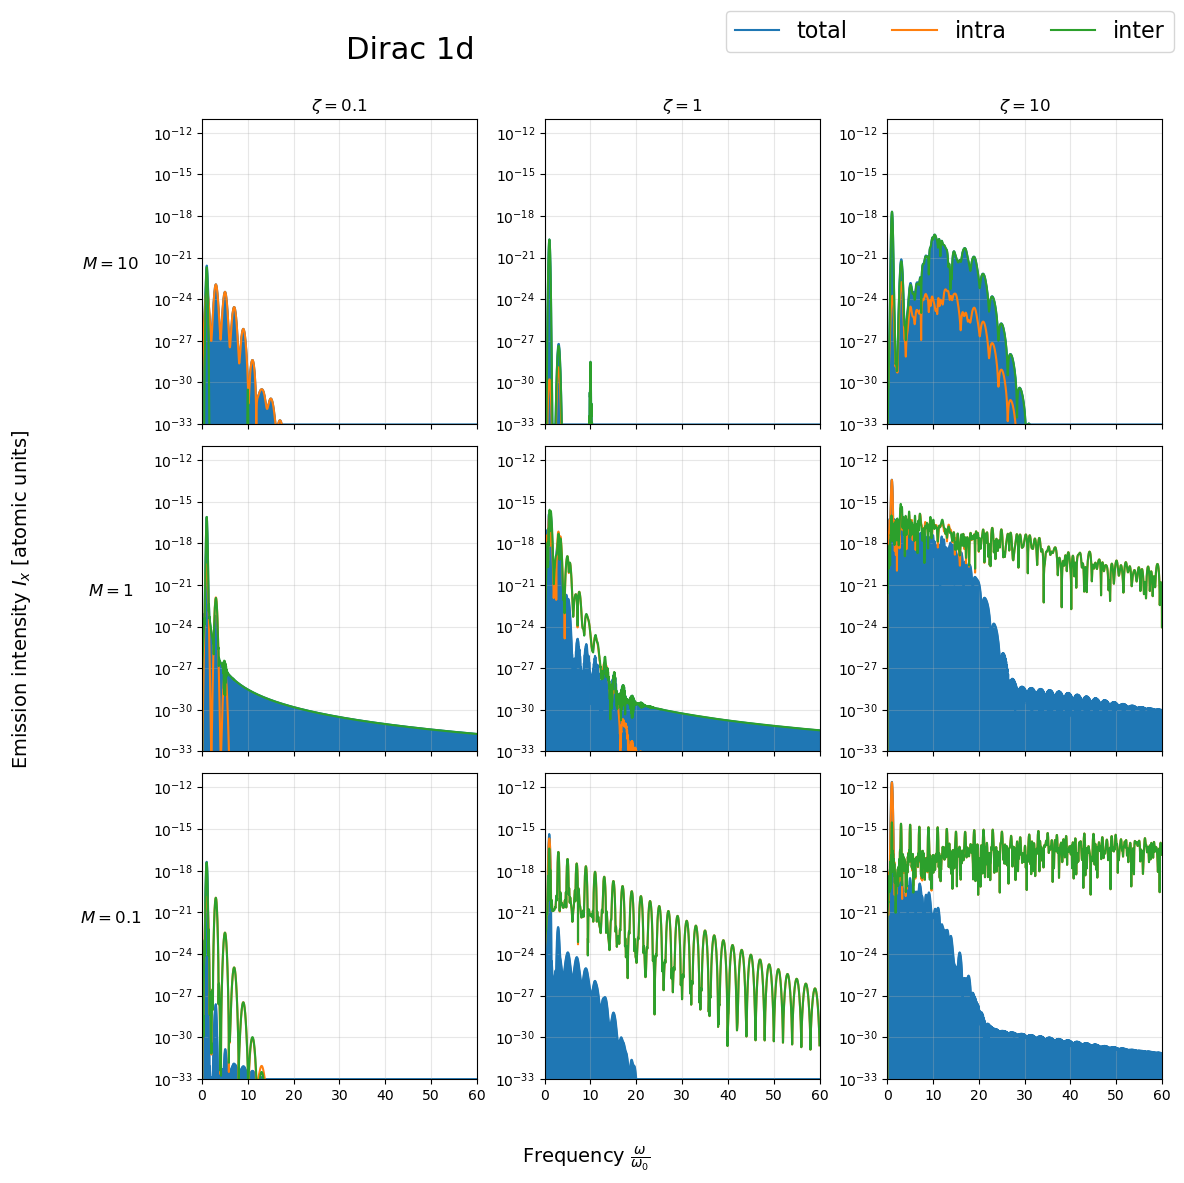

In [13]:
import matplotlib.pyplot as plt
import numpy as np

path1d = '/home/how09898/phd/data/dirac/zeta-M-sweep1/3x3_final1d_1e-2'
data = load_hdf5_files(path1d)

# transpose & flip data
dat = np.flip(np.matrix(data).reshape((3,3)).transpose(),axis=0).flat

# Create a 3x3 grid layout for subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=False)

col_titles = [r"$\zeta = 0.1$",r"$\zeta = 1$",r"$\zeta = 10$"]
row_titles = [r"$M = 10$",r"$M = 1$",r"$M = 0.1$"]

ylim = (1e-33,1e-11)

# Plot the time-series in each subplot
for i, ax in enumerate(axes.flat):
    spectrum_ax(dat[i],ax,xlabel="",ylabel="",ylim=ylim,maxharm=60)
    
for ax, col in zip(axes[0], col_titles):
    ax.set_title(col)
    
for ax, row in zip(axes[:,0], row_titles):
    ax.set_ylabel(row, rotation=0,size='large',labelpad=30)

# Adjust layout to make space for the shared legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Create a shared legend outside the plots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=3, fontsize=16)

# Add labels to the shared axes
fig.text(0.5, 0.03, r"Frequency $\frac{\omega}{\omega_0}$", ha="center", fontsize=14)
fig.text(0.02, 0.5, r"Emission intensity $I_x$ [atomic units]", va="center", rotation="vertical", fontsize=14)
fig.text(0.3,0.95,"Dirac 1d", fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.9,bottom=0.1,left=0.18)

fig.savefig(fname="3x3_spectra_1d.png", dpi=300)

# Show the plot
plt.show()


## 3x3 Velocities 2D

Found 9 .hdf5 files.


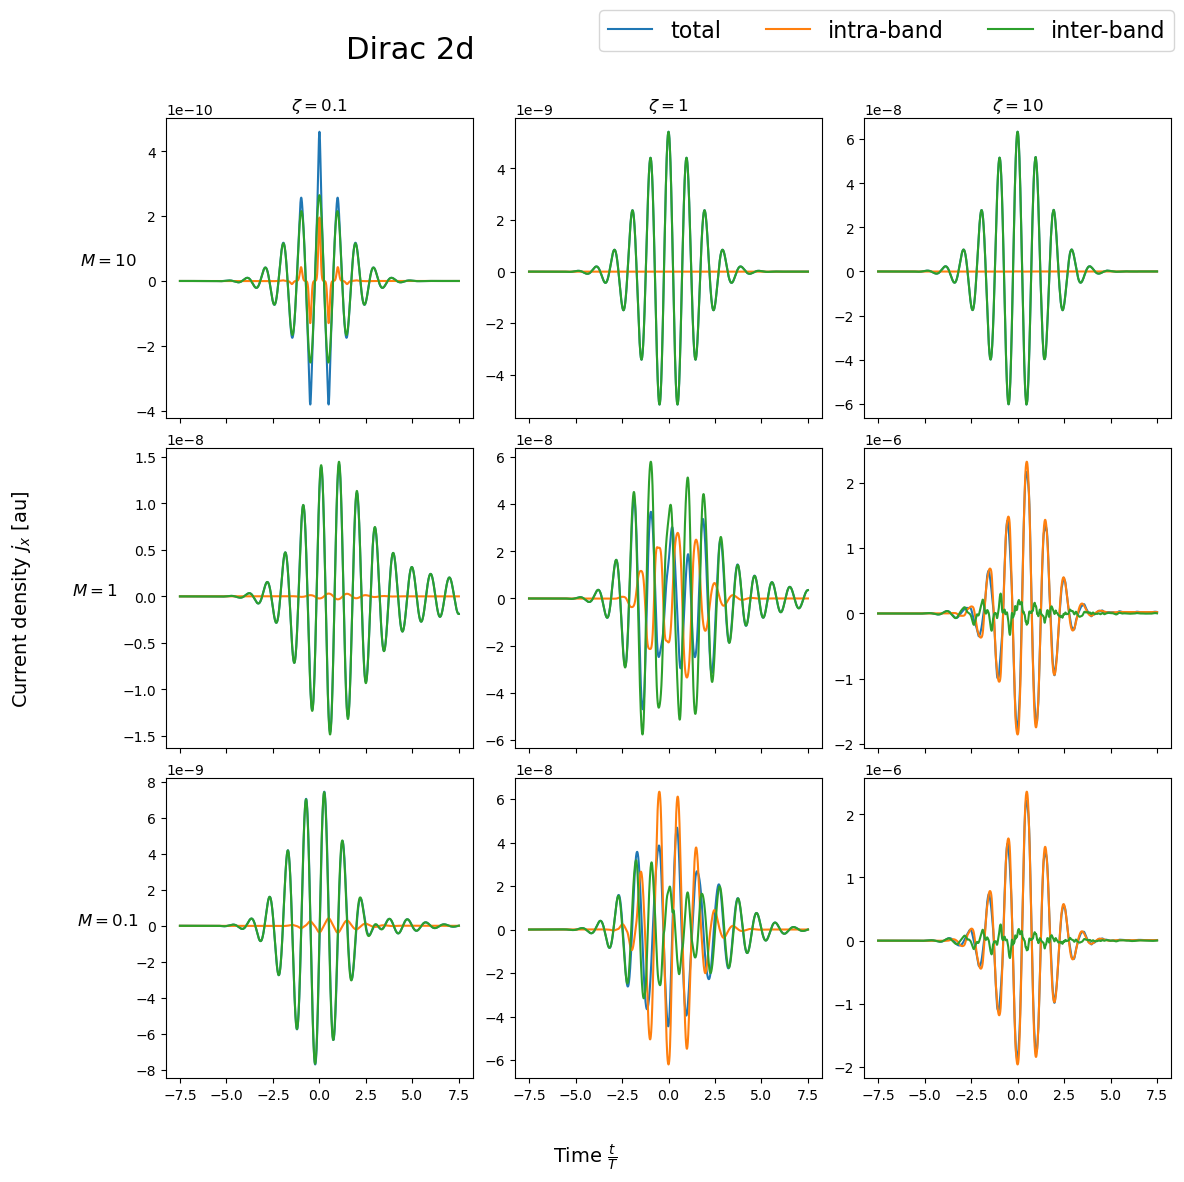

In [14]:
import matplotlib.pyplot as plt
import numpy as np

path = '/home/how09898/phd/data/dirac/zeta-M-sweep1/3x3_final2d_1e-2'
data = load_hdf5_files(path)

# transpose & flip data
dat = np.flip(np.matrix(data).reshape((3,3)).transpose(),axis=0).flat

# Create a 3x3 grid layout for subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=False)

col_titles = [r"$\zeta = 0.1$",r"$\zeta = 1$",r"$\zeta = 10$"]
row_titles = [r"$M = 10$",r"$M = 1$",r"$M = 0.1$"]

# Plot the time-series in each subplot
for i, ax in enumerate(axes.flat):
    j = current_density_au(dat[i])
    ts = dat[i]['numericalparams']['tsamples']
    ax.plot(ts, j['jx'], label="total")
    ax.plot(ts, j['jxintra'], label="intra-band")
    ax.plot(ts, j['jxinter'], label="inter-band")
    # ax.set_title(format_string(dat[i]['id'].decode('UTF-8')))
    
for ax, col in zip(axes[0], col_titles):
    ax.set_title(col)
    
for ax, row in zip(axes[:,0], row_titles):
    ax.set_ylabel(row, rotation=0,size='large',labelpad=20)

# Adjust layout to make space for the shared legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Create a shared legend outside the plots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=3, fontsize=16)

# Add labels to the shared axes
fig.text(0.5, 0.03, r"Time $\frac{t}{T}$", ha="center", fontsize=14)
fig.text(0.02, 0.5, r"Current density $j_x$ [au]", va="center", rotation="vertical", fontsize=14)
fig.text(0.3,0.95,"Dirac 2d", fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.9,bottom=0.1,left=0.15)

fig.savefig(fname="3x3_velocities_2d.png", dpi=300)

# Show the plot
plt.show()


## 3x3 Velocities 1D

Found 9 .hdf5 files.


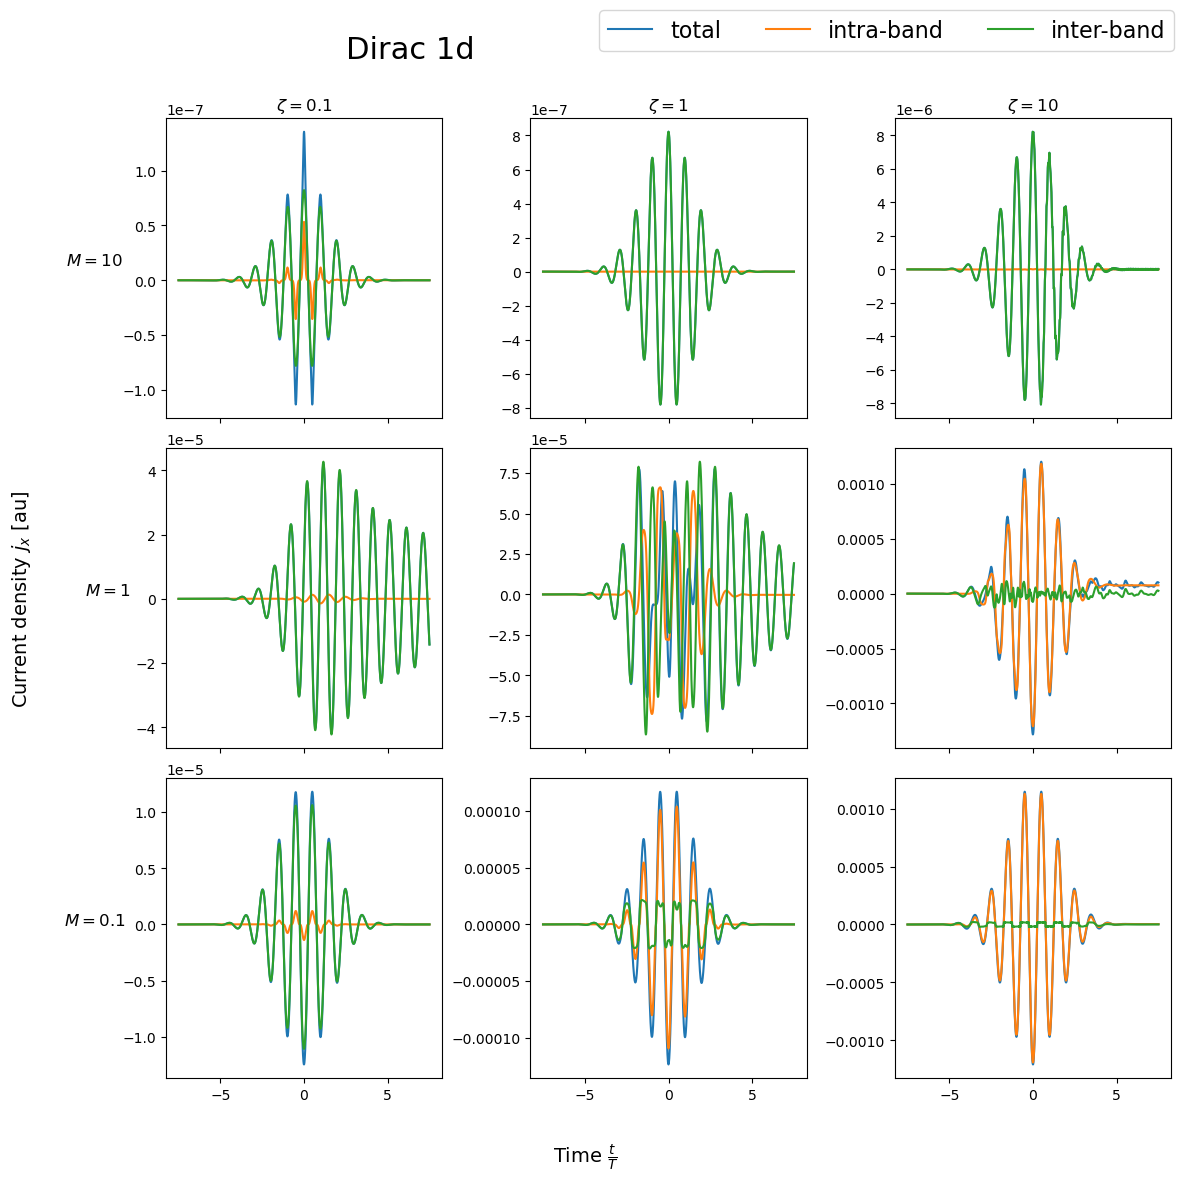

In [15]:
import matplotlib.pyplot as plt
import numpy as np

path1d = '/home/how09898/phd/data/dirac/zeta-M-sweep1/3x3_final1d_1e-2'
data = load_hdf5_files(path1d)

# transpose & flip data
dat = np.flip(np.matrix(data).reshape((3,3)).transpose(),axis=0).flat

# Create a 3x3 grid layout for subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=False)

col_titles = [r"$\zeta = 0.1$",r"$\zeta = 1$",r"$\zeta = 10$"]
row_titles = [r"$M = 10$",r"$M = 1$",r"$M = 0.1$"]

# Plot the time-series in each subplot
for i, ax in enumerate(axes.flat):
    j = current_density_au(dat[i])
    ts = dat[i]['numericalparams']['tsamples']
    ax.plot(ts, j['jx'], label="total")
    ax.plot(ts, j['jxintra'], label="intra-band")
    ax.plot(ts, j['jxinter'], label="inter-band")
    # ax.set_title(format_string(dat[i]['id'].decode('UTF-8')))
    
for ax, col in zip(axes[0], col_titles):
    ax.set_title(col)
    
for ax, row in zip(axes[:,0], row_titles):
    ax.set_ylabel(row, rotation=0,size='large',labelpad=20)

# Adjust layout to make space for the shared legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Create a shared legend outside the plots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=3, fontsize=16)

# Add labels to the shared axes
fig.text(0.5, 0.03, r"Time $\frac{t}{T}$", ha="center", fontsize=14)
fig.text(0.02, 0.5, r"Current density $j_x$ [au]", va="center", rotation="vertical", fontsize=14)
fig.text(0.3,0.95,"Dirac 1d", fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.9,bottom=0.1,left=0.15)

fig.savefig(fname="3x3_velocities_1d.png", dpi=300)

# Show the plot
plt.show()


# Compare 1d to analytics

## Get zeta & M from sims

In [16]:
def zeta_dirac(simulation):
    df = simulation['drivingfield']
    return 2 * df['eE'] / df['ω']**2

def multiphoton_dirac(simulation):
    h = simulation['liouvillian']['hamiltonian']
    df = simulation['drivingfield']
    return 2 * h['m'] / df['ω']
    

In [17]:
for d in data1d:
    print(format_string(d['id'].decode('UTF-8')))
    print(zeta_dirac(d),multiphoton_dirac(d),'\n')
    

ζ = 0.1 M = 0.1
0.10000000000000002 0.1 

ζ = 0.1 M = 1.0
0.10000000000000002 1.0 

ζ = 0.1 M = 10.0
0.10000000000000002 9.999999999999998 

ζ = 1.0 M = 0.1
1.0 0.1 

ζ = 1.0 M = 1.0
1.0 1.0 

ζ = 1.0 M = 10.0
1.0 9.999999999999998 

ζ = 10.0 M = 0.1
10.000000000000002 0.1 

ζ = 10.0 M = 1.0
10.000000000000002 1.0 

ζ = 10.0 M = 10.0
10.000000000000002 9.999999999999998 



## Scaling for $\zeta$ & M

Quick recap of neat scaling:
$$ H = \frac{t_c}{\hbar}\mathcal{H} = \frac{1}{\hbar\omega_0} \mathcal{H} 
    = \frac{\zeta}{2}\left[\kappa_x\sigma_x + \kappa_y\sigma_y\right] + \frac{M}{2}\sigma_z$$
$$ \vec{k}(t) 
    = \vec{k} - \frac{e}{\hbar}\vec{A}(t) 
    = \frac{e E_0}{\hbar\omega_0} \left[\vec{\kappa}-\vec{a}(t)\right] 
    = \frac{1}{l_c}\vec{\kappa}(t)$$

$$ t_c = \frac{1}{\omega_0} ~~~ l_c = \frac{\hbar\omega_0}{e E_0} $$

In [18]:
def velocity_nice_dimless(simulation):
    
    tc      = 1 / angular_frequency_SI(simulation)
    d       = simulation['dim']
    e       = sp.constants.elementary_charge
    omega0  = angular_frequency_SI(simulation)
    hbar    = sp.constants.hbar
    E_0     = peak_field_strength_SI(simulation)
    
    lc      = hbar*omega0 / (e*E_0) 
    
    v_SI        = velocity_SI(simulation)
    v_scaled    = {}
    
    for k,v in v_SI.items():
        v_scaled[k] = v * tc * lc**(d-1)
    return v_scaled

def vecpot_x_nice_dimless(simulation):
    
    us      = simulation['unitscaling']
    e       = sp.constants.elementary_charge
    omega0  = angular_frequency_SI(simulation)
    hbar    = sp.constants.hbar
    E_0     = peak_field_strength_SI(simulation)
    
    ax_SI   = hbar * simulation['drivingfield']['ax'] / (e * lengthscale_SI(us))
    
    return  omega0 * ax_SI / E_0
    

## Compare 1D to analytics

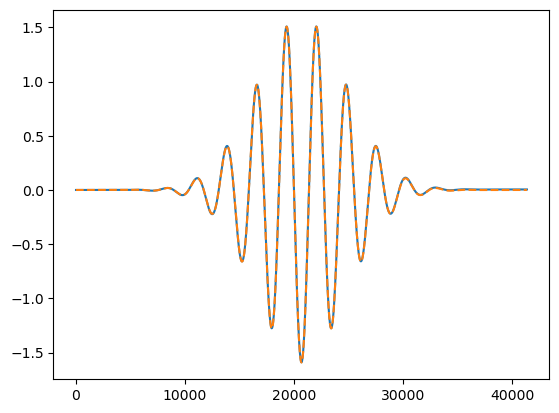

In [ ]:
sim     = data1d[6]
zeta    = zeta_dirac(sim)
v       = velocity_nice_dimless(sim)
ax      = vecpot_x_nice_dimless(sim)

plt.plot(v['vx'])
plt.plot(-zeta * ax / (2*np.pi),'--')
plt.show()

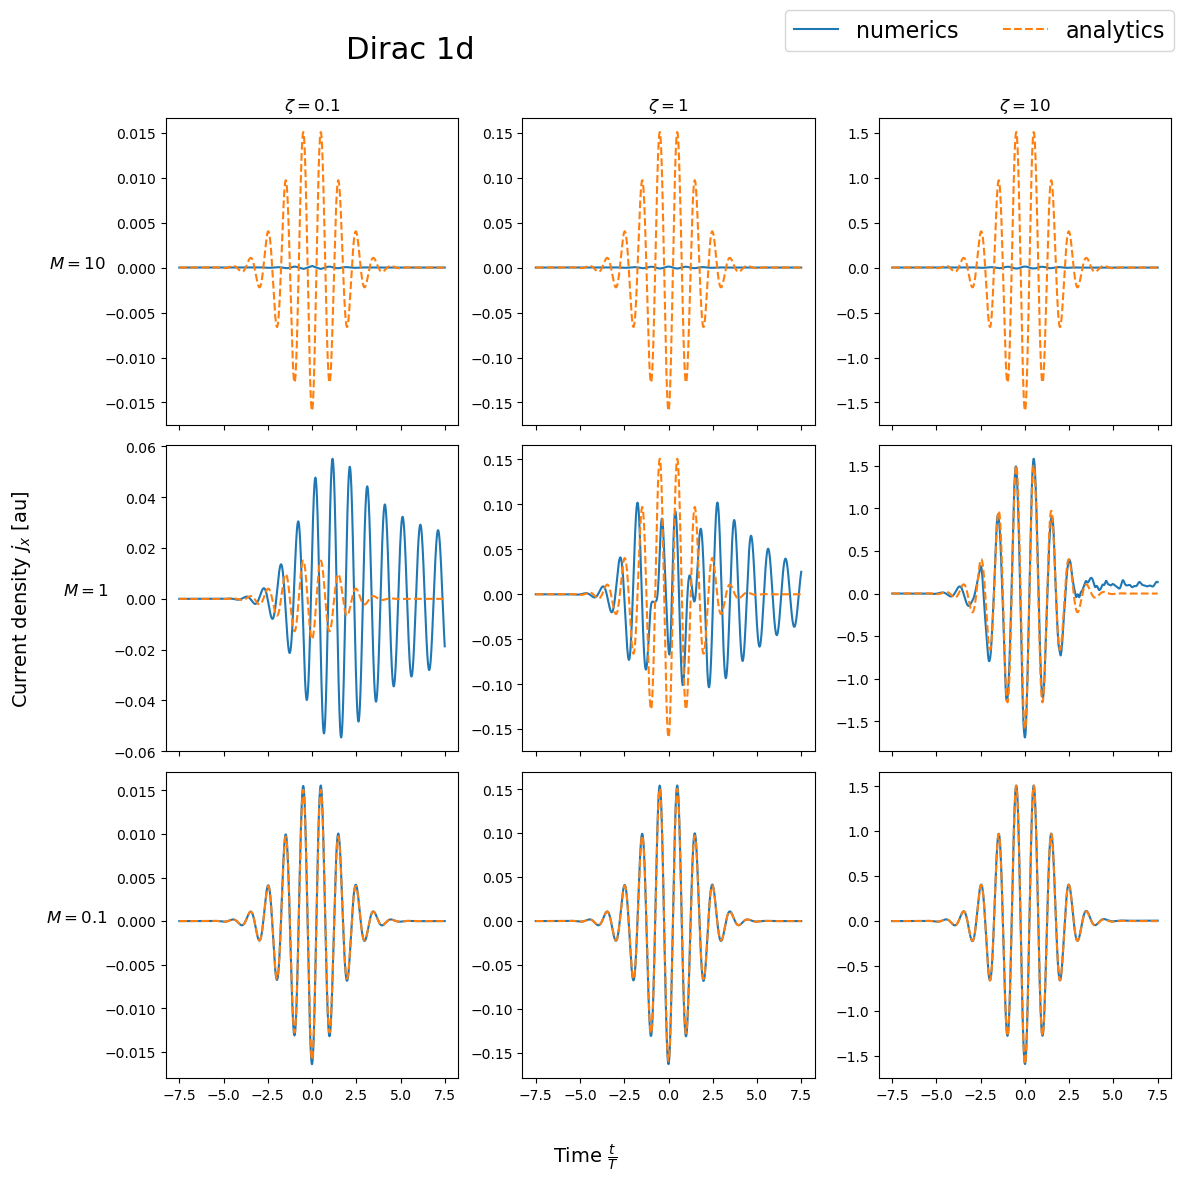

In [20]:
# transpose & flip data
dat = np.flip(np.matrix(data).reshape((3,3)).transpose(),axis=0).flat

# Create a 3x3 grid layout for subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=False)

col_titles = [r"$\zeta = 0.1$",r"$\zeta = 1$",r"$\zeta = 10$"]
row_titles = [r"$M = 10$",r"$M = 1$",r"$M = 0.1$"]

# Plot the time-series in each subplot
for i, ax in enumerate(axes.flat):
    v_numeric   = velocity_nice_dimless(dat[i])
    zeta        = zeta_dirac(dat[i])
    v_analytic  = -zeta * vecpot_x_nice_dimless(dat[i])  / (2*np.pi)
    ts = dat[i]['numericalparams']['tsamples']
    ax.plot(ts, v_numeric['vx'], label="numerics")
    ax.plot(ts, v_analytic, '--', label="analytics")
    # ax.set_title(format_string(dat[i]['id'].decode('UTF-8')))
    
for ax, col in zip(axes[0], col_titles):
    ax.set_title(col)
    
for ax, row in zip(axes[:,0], row_titles):
    ax.set_ylabel(row, rotation=0,size='large',labelpad=20)

# Adjust layout to make space for the shared legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Create a shared legend outside the plots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=3, fontsize=16)

# Add labels to the shared axes
fig.text(0.5, 0.03, r"Time $\frac{t}{T}$", ha="center", fontsize=14)
fig.text(0.02, 0.5, r"Current density $j_x$ [au]", va="center", rotation="vertical", fontsize=14)
fig.text(0.3,0.95,"Dirac 1d", fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.9,bottom=0.1,left=0.15)

fig.savefig(fname="3x3_velocities_analytics.png", dpi=300)

# Show the plot
plt.show()

# Noise cutoff

## 1D

In [21]:
def gaussian_kernel(size, sigma):
    """
    Create a Gaussian kernel.

    Parameters:
        size (int): The size of the kernel (should be odd).
        sigma (float): The standard deviation of the Gaussian.

    Returns:
        np.ndarray: The normalized Gaussian kernel.
    """
    x = np.arange(-size // 2, size // 2 + 1)
    kernel = np.exp(-(x ** 2) / (2 * sigma ** 2))
    return kernel / np.sum(kernel)  # Normalize the kernel

def pad_with_edge_values(x, pad_size):
    """
    Pad a 1D signal with edge values.

    Parameters:
        x (np.ndarray): The input signal.
        pad_size (int): The size of the padding on each side.

    Returns:
        np.ndarray: The padded signal.
    """
    left_pad = np.full(pad_size, x[0])
    right_pad = np.full(pad_size, x[-1])
    return np.concatenate([left_pad, x, right_pad])

def gaussian_smoothing_fft(x, sigma):
    """
    Apply Gaussian smoothing using FFT with edge value padding.

    Parameters:
        x (np.ndarray): The input signal.
        sigma (float): The standard deviation of the Gaussian.

    Returns:
        np.ndarray: The smoothed signal.
    """
    n = len(x)
    
    # Define the size of the kernel (typically 6 * sigma to capture most of the Gaussian curve)
    kernel_size = min(n, max(1, int(round(6 * sigma))))
    if kernel_size % 2 == 0:  # Ensure the kernel size is odd
        kernel_size += 1

    # Create Gaussian kernel
    kernel = gaussian_kernel(kernel_size, sigma)

    # Calculate the padding size
    pad_size = kernel_size // 2

    # Pad the input signal with edge values
    x_padded = pad_with_edge_values(x, pad_size)

    # Pad the signal and kernel to the next power of 2 for efficient FFT
    padded_size = 2 ** int(np.ceil(np.log2(len(x_padded) + kernel_size - 1)))
    x_padded = np.concatenate([x_padded, np.zeros(padded_size - len(x_padded))])
    kernel_padded = np.concatenate([kernel, np.zeros(padded_size - len(kernel))])

    # Perform FFT
    X = np.fft.rfft(x_padded)
    K = np.fft.rfft(kernel_padded)

    # Convolution in frequency domain
    Y = X * K

    # Inverse FFT to get the convolution result
    y_padded = np.fft.irfft(Y, n=padded_size)

    # Trim the result to match the original signal length, excluding the padding
    y = y_padded[pad_size:pad_size + n]

    return y

def noiselimit(data,limit=1e-10,smoothing_sigma=3.0):
    smoothed_data = gaussian_smoothing_fft(data,smoothing_sigma)
    smoothed_data = smoothed_data / np.max(smoothed_data)
    i = 100
    while smoothed_data[i] > limit and i < len(data)-1:
        i += 1
    return i


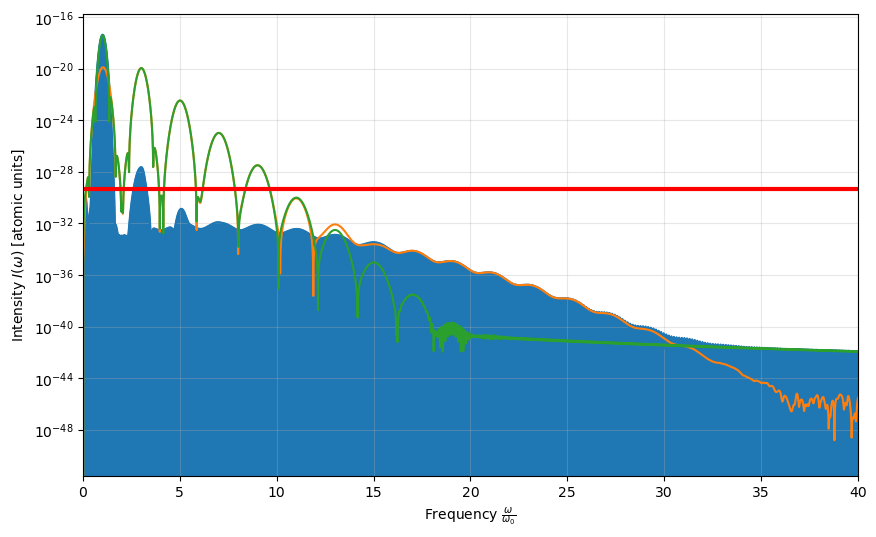

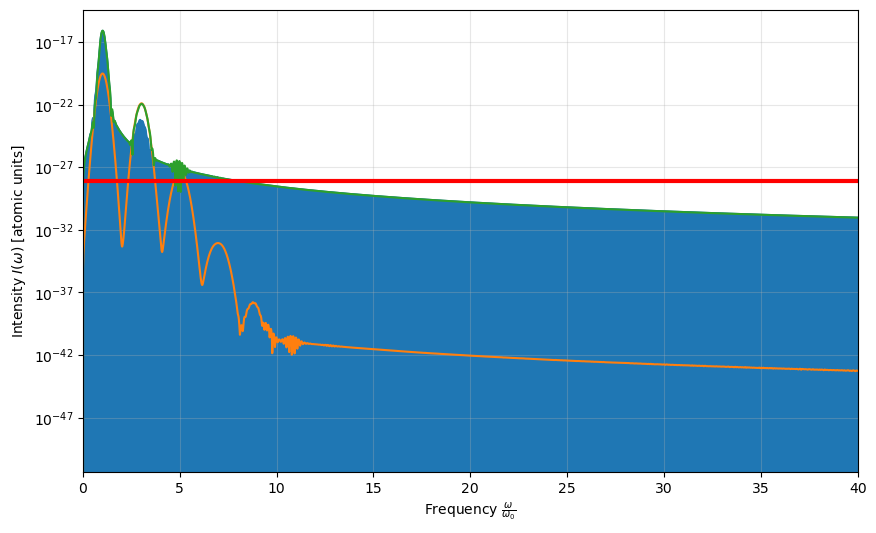

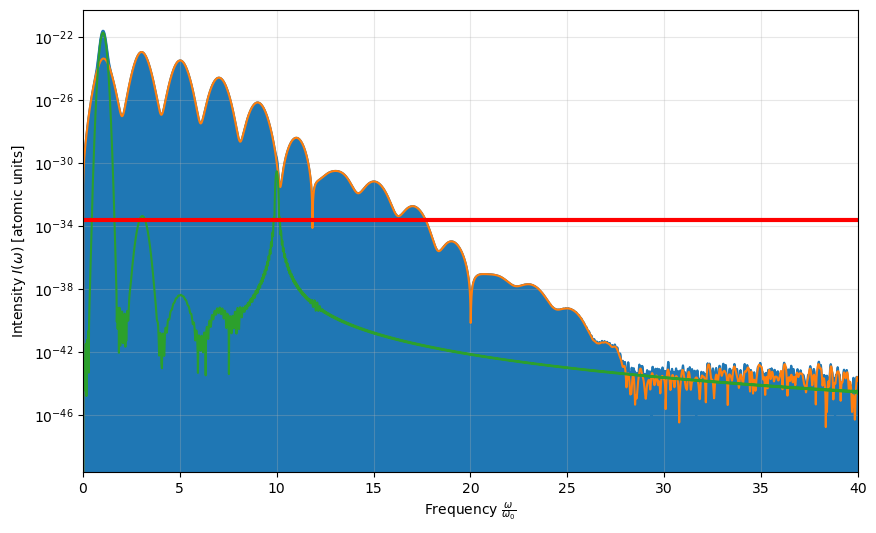

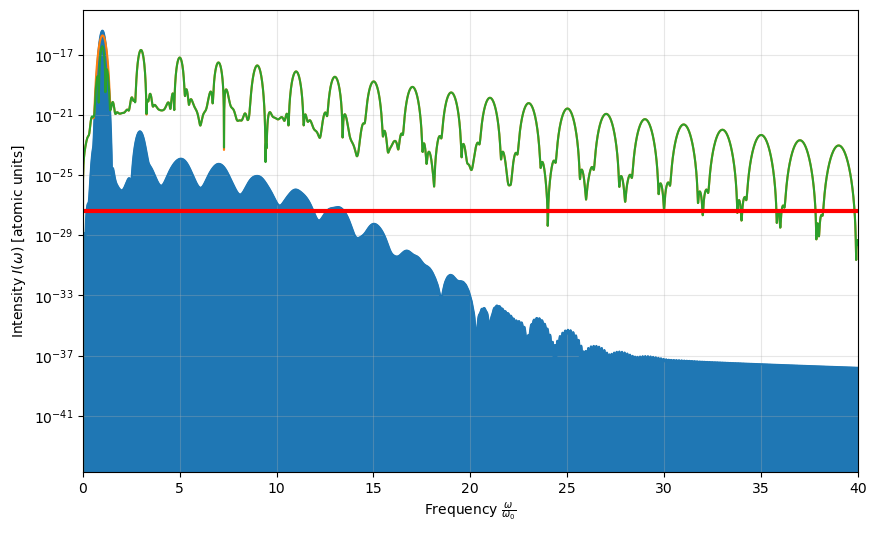

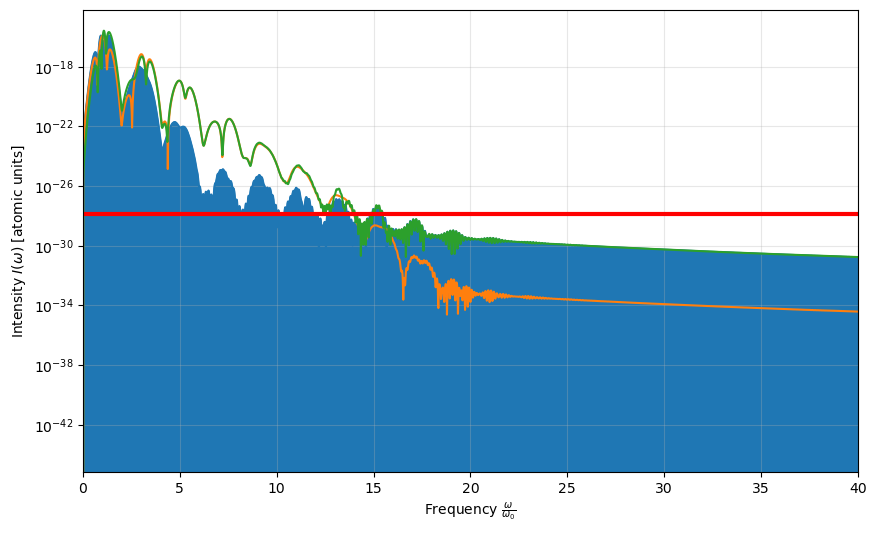

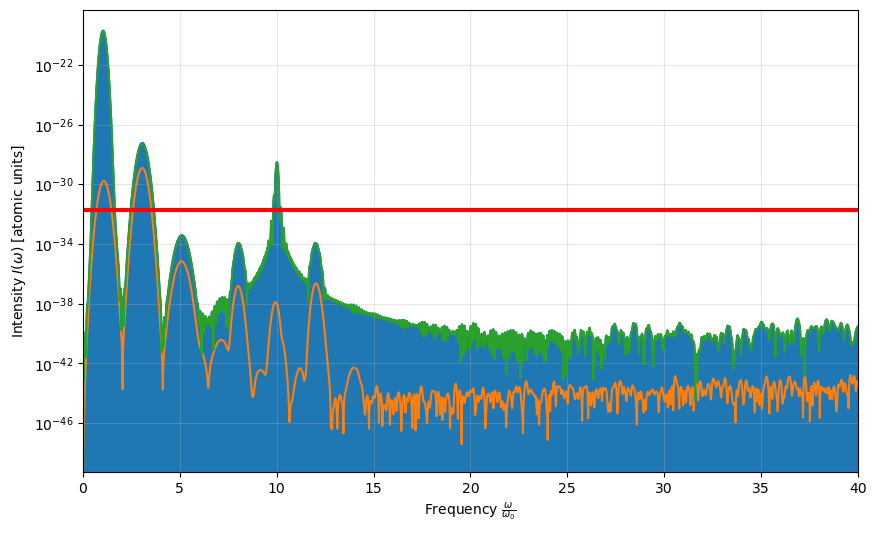

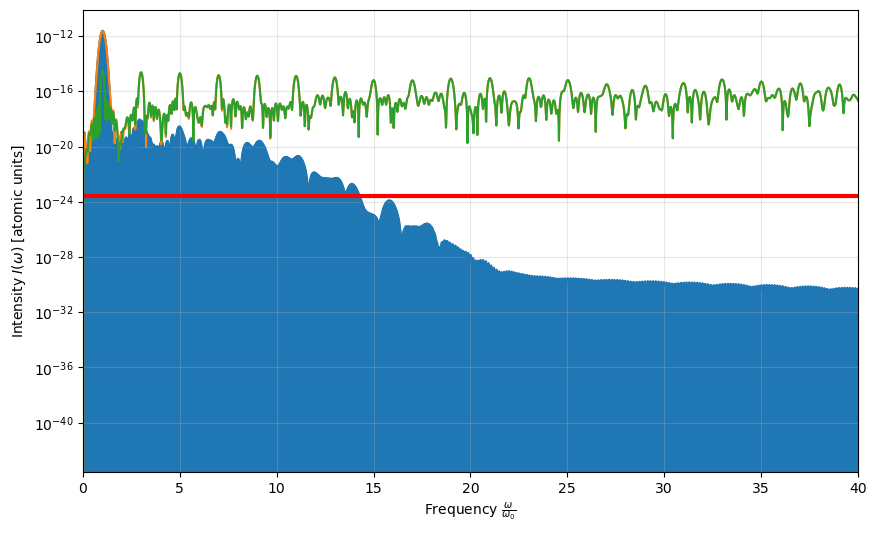

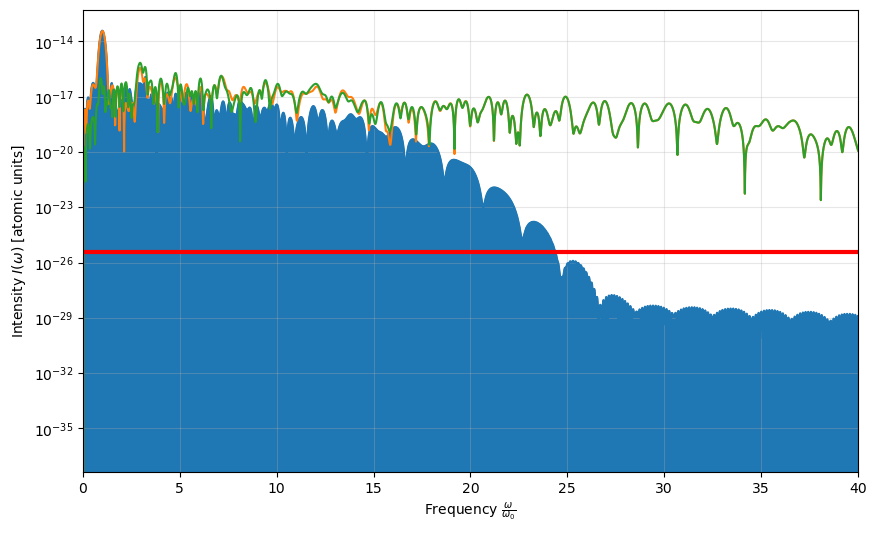

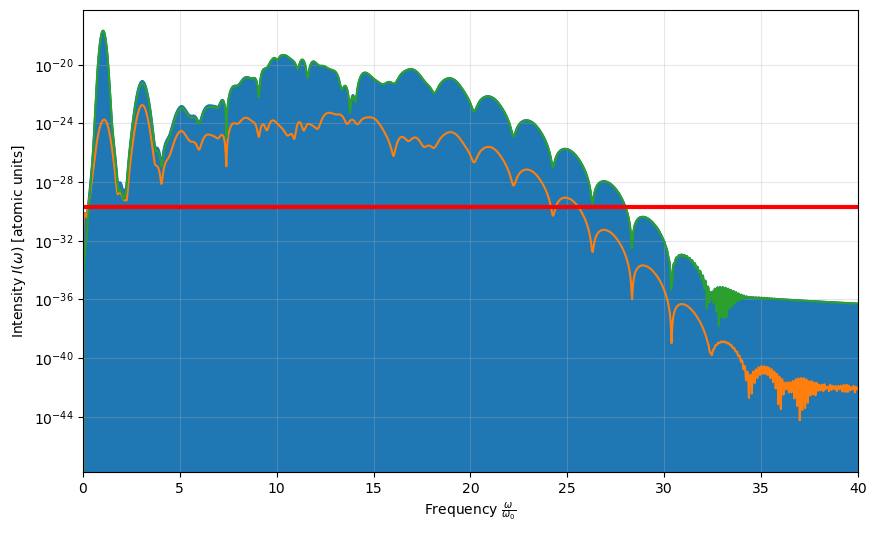

In [22]:
def plot_simple_cutoff(sim):
    j   = current_density_au(sim)
    fig = plt.figure(figsize=(10, 6))
    ax  = fig.add_subplot(1, 1, 1)

    spectrum_ax(sim,ax)
    ax.hlines(1e-12*np.max(ax.get_lines()[0].get_ydata()),0,40,color='red',linewidth=3)
    
    return fig

for s in data1d:
    f = plot_simple_cutoff(s)
    f.show()



In [23]:
ln=ax.get_lines()[0]
ln.get_ydata()

array([3.23968640e-18, 5.51277432e-10, 1.08843363e-09, ...,
       6.73474697e-08, 6.70754731e-08, 6.67971946e-08])

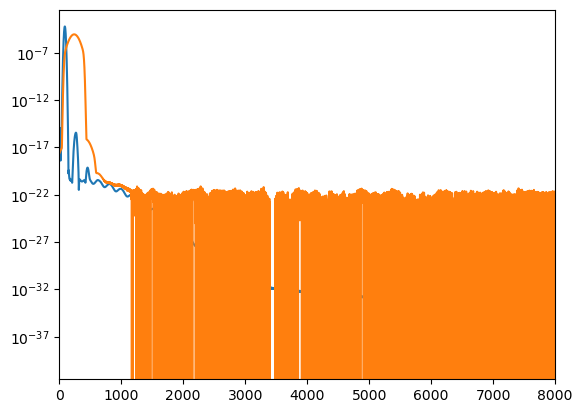

In [24]:
sim=data1d[0]
j=current_density_au(sim)
d_fft,freqs = real_fourier_trafo(j['jx'],1/sim['numericalparams']['dt'],5*len(j["jx"]))
smooth_fft = gaussian_smoothing_fft(np.abs(d_fft)**2,50)
plt.semilogy(np.abs(d_fft)**2)
plt.semilogy(smooth_fft)
plt.xlim(0,8000)
plt.show()

In [25]:
freqs[d_fft > 1e-18]

array([1.11094369e-02, 2.22188739e-02, 3.33283108e-02, ...,
       1.76773361e+02, 1.76895564e+02, 1.76906674e+02])

In [26]:
def mask_above_threshold(sim,threshold_factor=1e-8):
    j           = current_density_au(sim)
    d_fft,freqs = real_fourier_trafo(j['jx'],1/sim['numericalparams']['dt'],5*len(j["jx"]))
    d_fftra,_ = real_fourier_trafo(j['jxintra'],1/sim['numericalparams']['dt'],5*len(j["jx"]))
    d_ffter,_ = real_fourier_trafo(j['jxinter'],1/sim['numericalparams']['dt'],5*len(j["jx"]))

    ydata = np.abs(d_fft)
    max = 1e-8 * np.max(ydata)
    return ydata > max

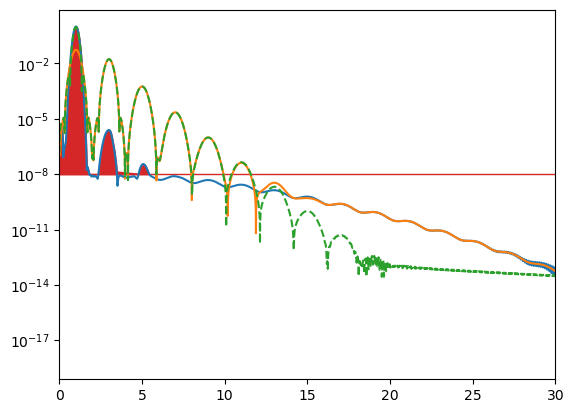

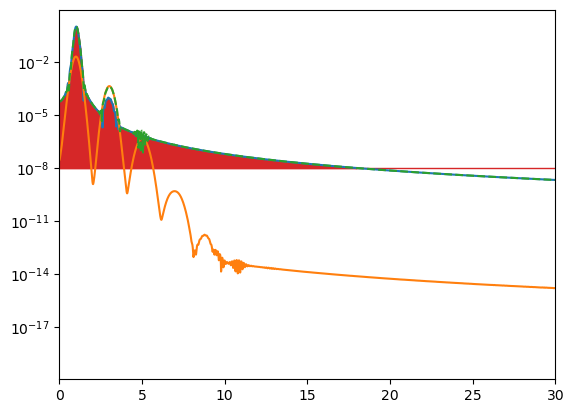

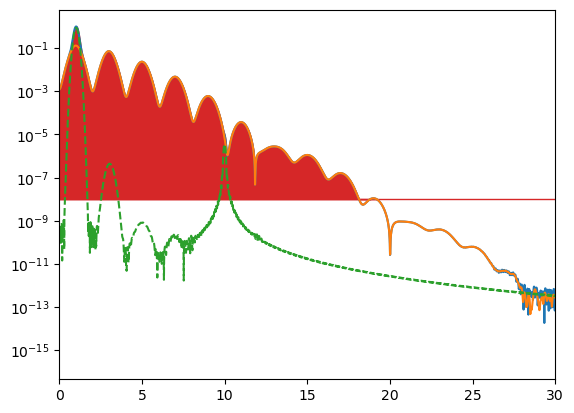

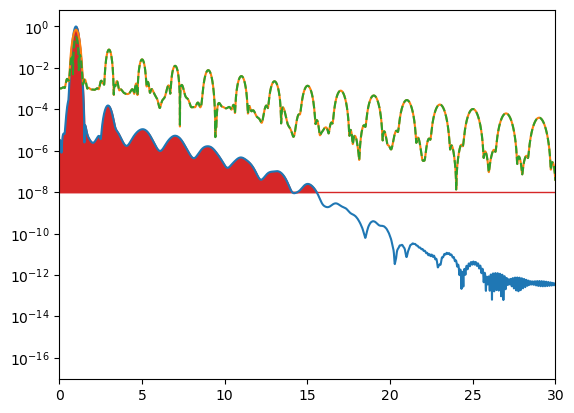

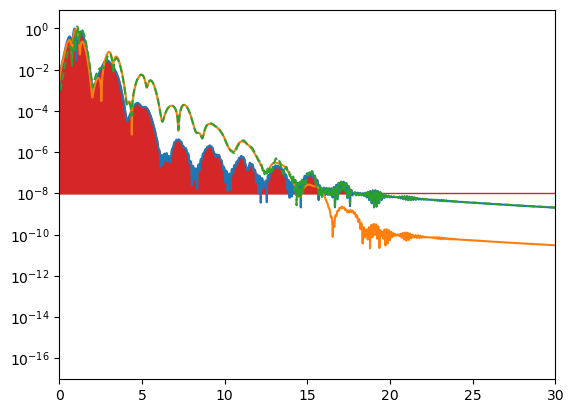

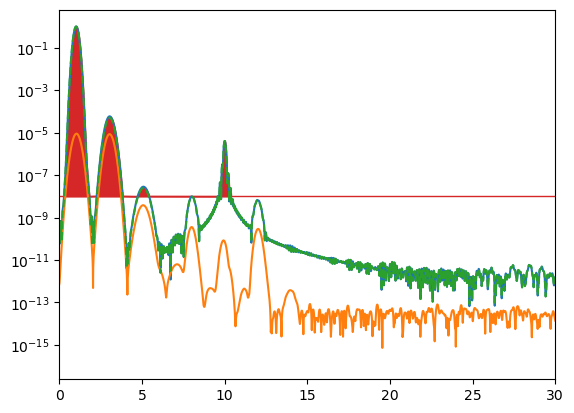

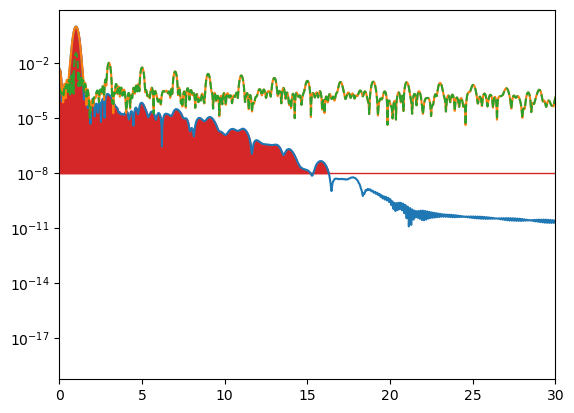

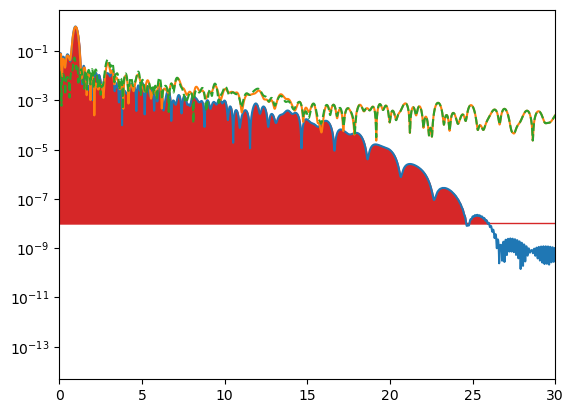

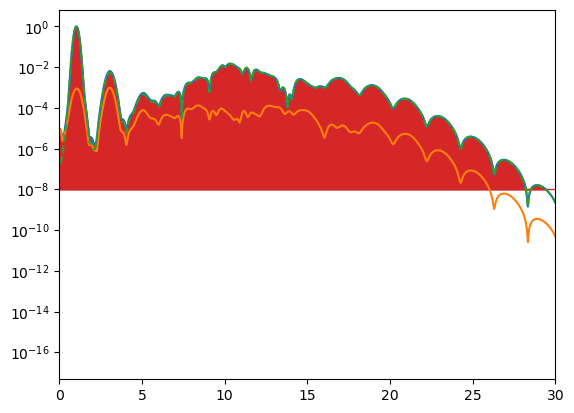

In [27]:
for sim in data1d:
    j=current_density_au(sim)
    d_fft,freqs = real_fourier_trafo(j['jx'],1/sim['numericalparams']['dt'],5*len(j["jx"]))
    d_fftra,_ = real_fourier_trafo(j['jxintra'],1/sim['numericalparams']['dt'],5*len(j["jx"]))
    d_ffter,_ = real_fourier_trafo(j['jxinter'],1/sim['numericalparams']['dt'],5*len(j["jx"]))

    ydata = np.abs(d_fft)
    max   = np.max(ydata)
    above_threshold = mask_above_threshold(sim,1e-8)

    plt.hlines(1e-8,0,30,color='C3',linewidth=1)
    plt.fill_between(freqs[above_threshold],ydata[above_threshold]/max,1e-8,color='C3')
    plt.semilogy(freqs,ydata/max)
    plt.semilogy(freqs,np.abs(d_fftra)/max)
    plt.semilogy(freqs,np.abs(d_ffter)/max,'--')
    plt.xlim(0,30)
    plt.show()

# R plot (1D data)

In [28]:
kxdata = load_hdf5_files("/home/how09898/phd/data/dirac/zeta-M-sweep1/17x17_kxmax_1e-2")

Found 280 .hdf5 files.


In [29]:
def sort_by_hash_number(strings):
    return sorted(strings, key=lambda s: int(s.split('_')[0][1:]))

def get_testsim_by_index(testresult,index,clip=True):
    ids = [s['id'].decode('ASCII') for _,s in testresult['completedsims'].items()]
    id  = sort_by_hash_number(ids)[min(index,len(ids)-1) if clip else index]
    return testresult['completedsims'][id]

def last_testsim(testresult):
    return get_testsim_by_index(testresult,-1)
    
def extrap_testsim(testresult):
    lastsim = copy.deepcopy(last_testsim(testresult))
    lastsim['observables'] = testresult['extrapolated_results']
    return lastsim
    

def r1_ratio_extrap(testresult):
    return r1_ratio(extrap_testsim(testresult))

def r1_ratio_index(testresult,index):
    return r1_ratio(get_testsim_by_index(testresult,index))

def r1_ratio(sim,threshold=1e-8):
    mask    = mask_above_threshold(sim,threshold)
    spec    = intensity_au(sim)
    inter = spec['inter'][mask]
    total = spec['total'][mask]
    return np.nanmean(inter / total)

In [30]:
def calc_r1_data_extrap(testresults):
    return calc_r1_data_index(testresults,-1)

def calc_r1_data_index(testresults,index):
    zetas   = []
    ms      = []
    r1s     = []
    for result in testresults:
        sim = get_testsim_by_index(result,index)
        
        zetas.append(zeta_dirac(sim))
        ms.append(multiphoton_dirac(sim))
        r1s.append(r1_ratio_extrap(result))
    return [zetas,ms,r1s]
        

In [31]:
data0 = calc_r1_data_index(kxdata,0)
data1 = calc_r1_data_index(kxdata,1)

/tmp/ipykernel_4108695/3402458347.py:29: RuntimeWarning: invalid value encountered in divide
  return np.nanmean(inter / total)


## Compare $R_1$ for different kxmax iterations

/tmp/ipykernel_4108695/3402458347.py:29: RuntimeWarning: invalid value encountered in divide
  return np.nanmean(inter / total)


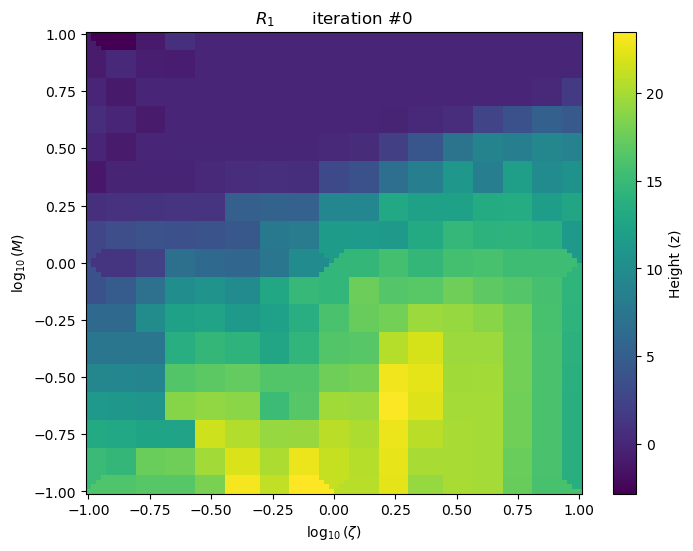

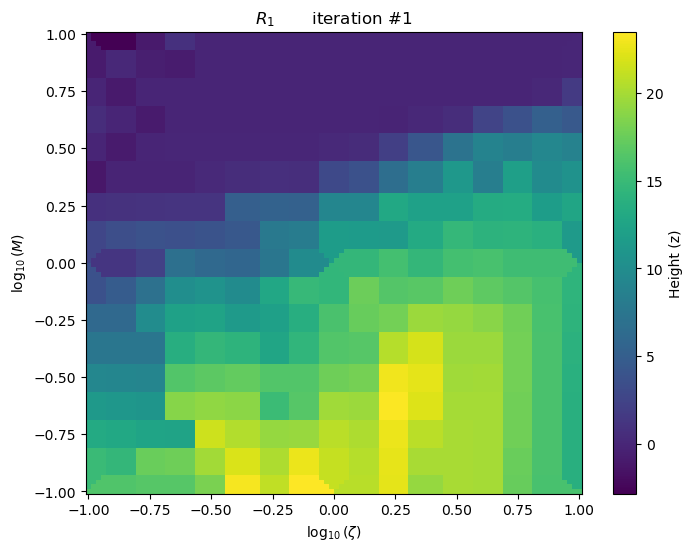

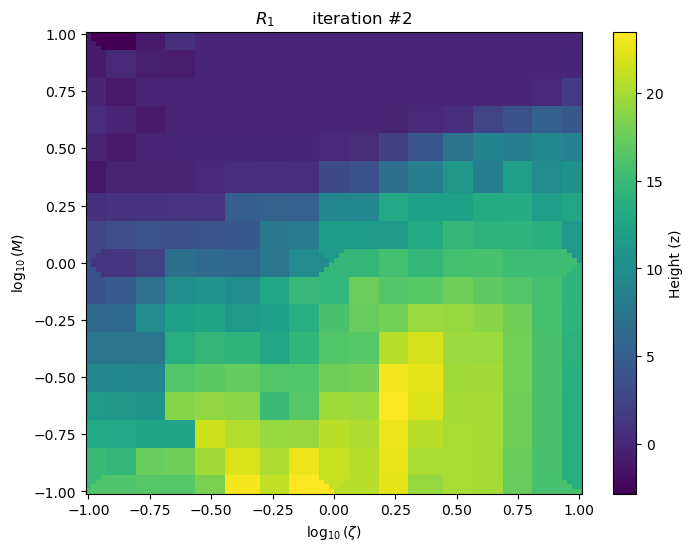

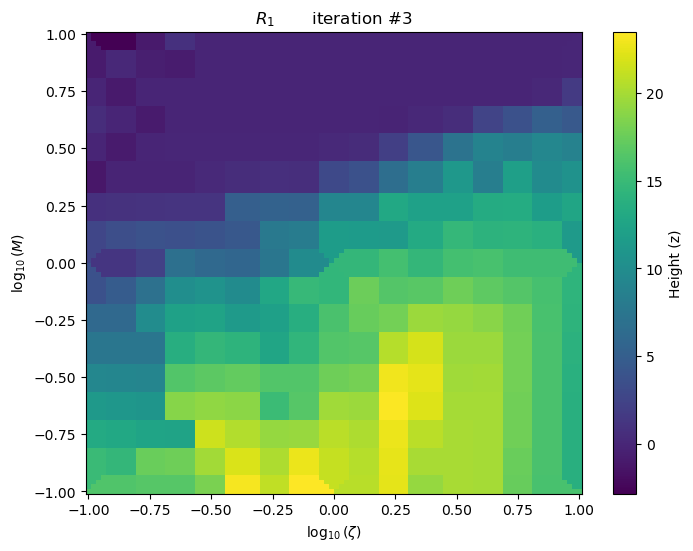

In [32]:
from scipy.interpolate import griddata

for i in range(4):
    
    zetas,ms,r1s = calc_r1_data_index(kxdata,i)

    x = np.log10(zetas)
    y = np.log10(ms)
    z = np.log(r1s)

    # Define the grid for interpolation
    xi = np.linspace(np.min(x), np.max(x), 100)  # Create a regular grid in x
    yi = np.linspace(np.min(y), np.max(y), 100)  # Create a regular grid in y
    xi, yi = np.meshgrid(xi, yi)           # Create a 2D grid

    # Interpolate the z values onto the regular grid
    zi = griddata((x, y), z, (xi, yi), method='nearest')  # 'linear', 'nearest', or 'cubic'

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    heatmap = plt.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis')
    plt.colorbar(heatmap, label='Height (z)')
    # plt.scatter(x, y, color='red', label='Data points')  # Optionally show the original points
    plt.xlabel(r'$\log_{10}(\zeta)$')
    plt.ylabel(r'$\log_{10}(M)$')
    # plt.legend()
    plt.title(r'$R_1$' + f"       iteration #{i}")
    plt.show()


In [33]:
r1_kxmax_index_data = [calc_r1_data_index(kxdata, i) for i in range(4)]

/tmp/ipykernel_4108695/3402458347.py:29: RuntimeWarning: invalid value encountered in divide
  return np.nanmean(inter / total)


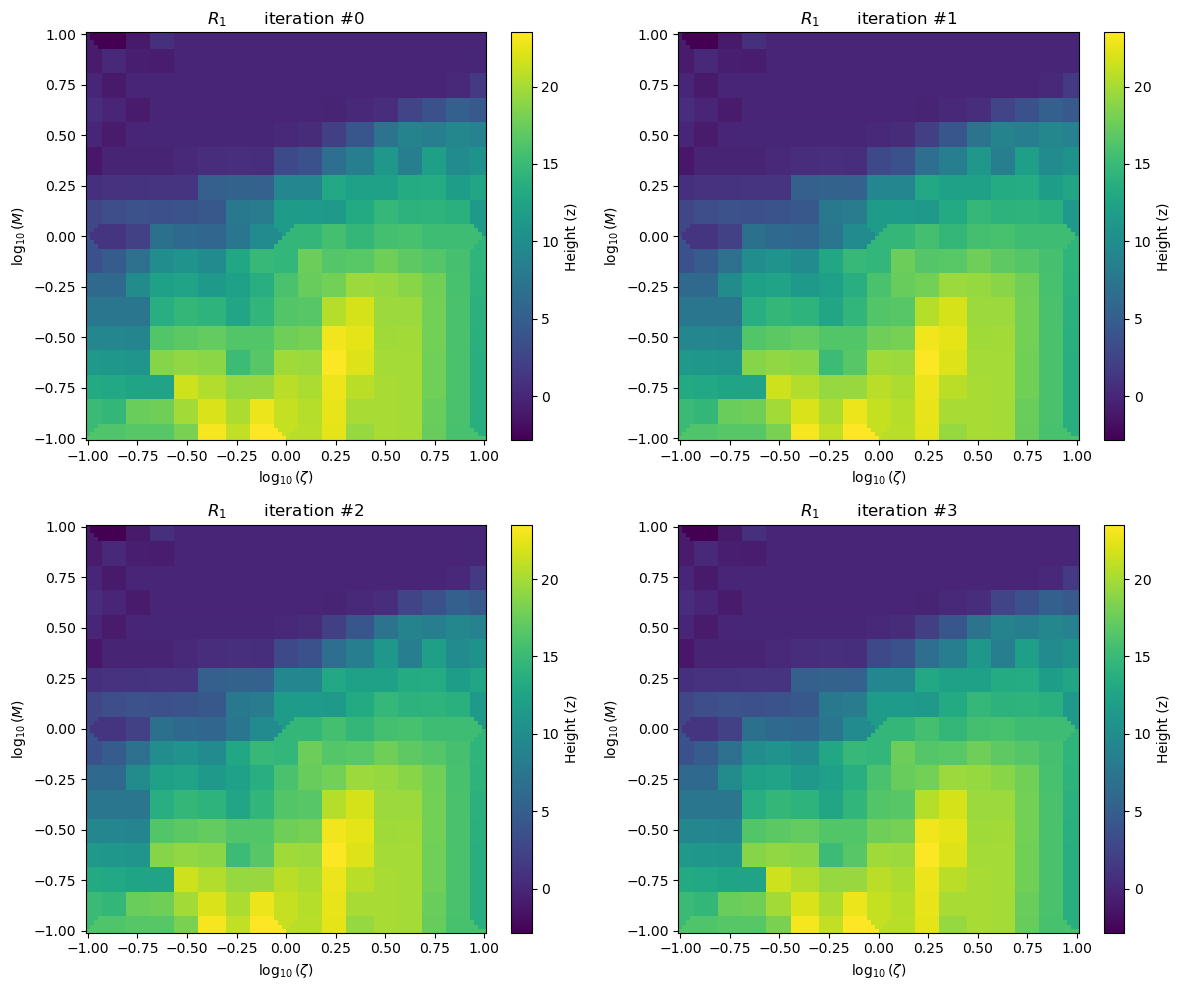

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i,dat in enumerate(r1_kxmax_index_data):
    zetas, ms, r1s = dat
    x = np.log10(zetas)
    y = np.log10(ms)
    z = np.log(r1s)

    # Define the grid for interpolation
    xi = np.linspace(np.min(x), np.max(x), 100)  # Create a regular grid in x
    yi = np.linspace(np.min(y), np.max(y), 100)  # Create a regular grid in y
    xi, yi = np.meshgrid(xi, yi)  # Create a 2D grid

    # Interpolate the z values onto the regular grid
    zi = griddata((x, y), z, (xi, yi), method='nearest')  # 'linear', 'nearest', or 'cubic'

    # Plot the heatmap
    ax = axes[i]
    heatmap = ax.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis')
    fig.colorbar(heatmap, ax=ax, label='Height (z)')
    ax.set_xlabel(r'$\log_{10}(\zeta)$')
    ax.set_ylabel(r'$\log_{10}(M)$')
    ax.set_title(r'$R_1$' + f"       iteration #{i}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
fig.savefig("r1-kxmax-convergence.png")

/tmp/ipykernel_4108695/3402458347.py:29: RuntimeWarning: invalid value encountered in divide
  return np.nanmean(inter / total)


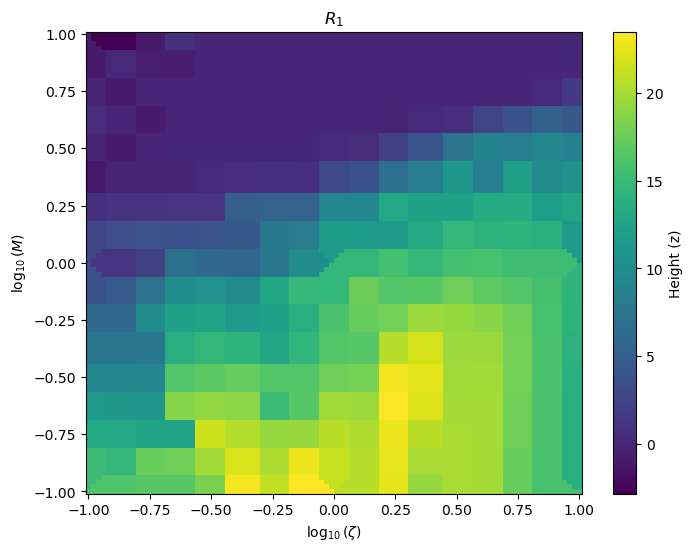

In [35]:
from scipy.interpolate import griddata

zetas,ms,r1s = calc_r1_data_extrap(kxdata)

x = np.log10(zetas)
y = np.log10(ms)
z = np.log(r1s)

# Define the grid for interpolation
xi = np.linspace(np.min(x), np.max(x), 100)  # Create a regular grid in x
yi = np.linspace(np.min(y), np.max(y), 100)  # Create a regular grid in y
xi, yi = np.meshgrid(xi, yi)           # Create a 2D grid

# Interpolate the z values onto the regular grid
zi = griddata((x, y), z, (xi, yi), method='nearest')  # 'linear', 'nearest', or 'cubic'

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis')
plt.colorbar(heatmap, label='Height (z)')
# plt.scatter(x, y, color='red', label='Data points')  # Optionally show the original points
plt.xlabel(r'$\log_{10}(\zeta)$')
plt.ylabel(r'$\log_{10}(M)$')
# plt.legend()
plt.title(r'$R_1$')
plt.show()


## Plot numerical parameters in heatmap

In [36]:
def getnumpar_index(testresult,index,parameter):
    sim = get_testsim_by_index(testresult,index)
    return sim["numericalparams"][parameter]

def getkxmax_index(testresult,index):
    return getnumpar_index(testresult,index,"kxmax")

In [37]:
zetas,ms,r1s = calc_r1_data_extrap(kxdata)

/tmp/ipykernel_4108695/3402458347.py:29: RuntimeWarning: invalid value encountered in divide
  return np.nanmean(inter / total)


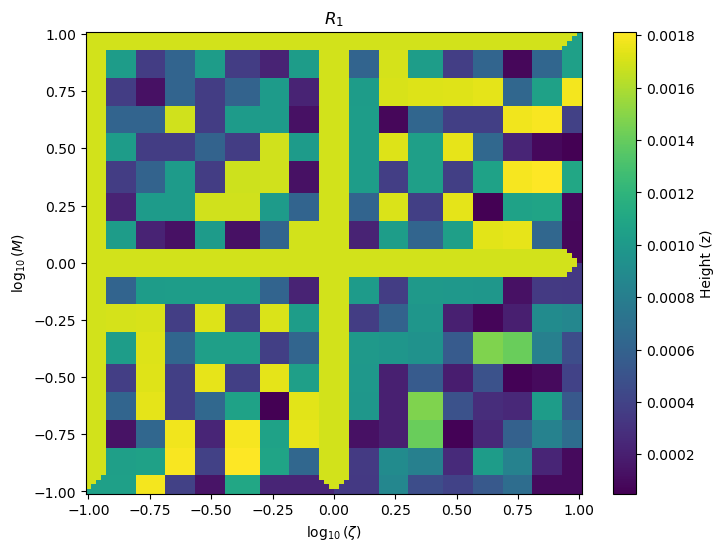

In [38]:
from scipy.interpolate import griddata

x = np.log10(zetas)
y = np.log10(ms)
# z = [np.abs(2*getnumpar_index(d,0,"t0")) / getnumpar_index(d,0,"dt") for d in kxdata]
z = [getnumpar_index(d,0,"dt") for d in kxdata]

# Define the grid for interpolation
xi = np.linspace(np.min(x), np.max(x), 100)  # Create a regular grid in x
yi = np.linspace(np.min(y), np.max(y), 100)  # Create a regular grid in y
xi, yi = np.meshgrid(xi, yi)           # Create a 2D grid

# Interpolate the z values onto the regular grid
zi = griddata((x, y), z, (xi, yi), method='nearest')  # 'linear', 'nearest', or 'cubic'

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis')
plt.colorbar(heatmap, label='Height (z)')
# plt.scatter(x, y, color='red', label='Data points')  # Optionally show the original points
plt.xlabel(r'$\log_{10}(\zeta)$')
plt.ylabel(r'$\log_{10}(M)$')
# plt.legend()
plt.title(r'$R_1$')
plt.show()


### Number of iterations

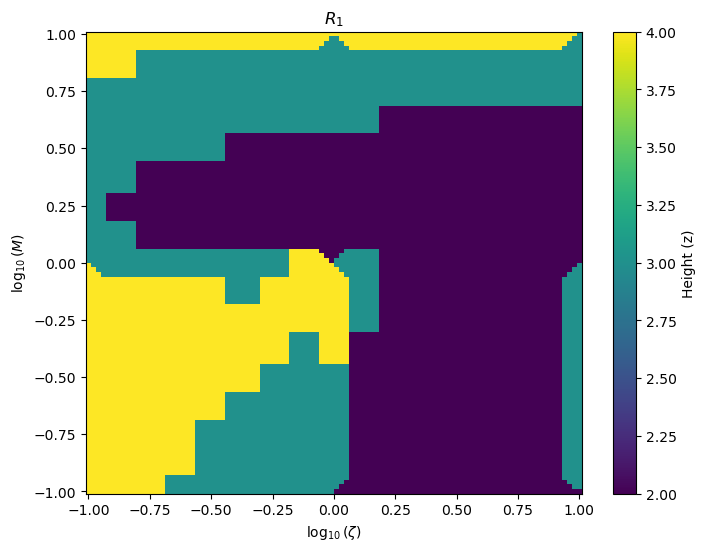

In [39]:
from scipy.interpolate import griddata

x = np.log10(zetas)
y = np.log10(ms)
z = [d["testresult"]["iterations"] for d in kxdata]

# Define the grid for interpolation
xi = np.linspace(np.min(x), np.max(x), 100)  # Create a regular grid in x
yi = np.linspace(np.min(y), np.max(y), 100)  # Create a regular grid in y
xi, yi = np.meshgrid(xi, yi)           # Create a 2D grid

# Interpolate the z values onto the regular grid
zi = griddata((x, y), z, (xi, yi), method='nearest')  # 'linear', 'nearest', or 'cubic'

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis')
plt.colorbar(heatmap, label='Height (z)')
# plt.scatter(x, y, color='red', label='Data points')  # Optionally show the original points
plt.xlabel(r'$\log_{10}(\zeta)$')
plt.ylabel(r'$\log_{10}(M)$')
# plt.legend()
plt.title(r'$R_1$')
plt.show()


## Compare $R_1$ for different kymax (just part of parameter space)

In [40]:
kydata_conv = load_hdf5_files("/home/how09898/phd/data/dirac/zeta-M-sweep1/17x17_kymax_1e-2")
kydata_rest = load_hdf5_files("/home/how09898/phd/data/dirac/zeta-M-sweep1/17x17_kymax_1e-2_maybe_continue")
kydata = kydata_rest + kydata_conv

Found 90 .hdf5 files.
Found 107 .hdf5 files.


In [41]:
zeta_range = sorted(list(dict.fromkeys(ms)))
m_range    = sorted(list(dict.fromkeys(zetas)))

In [42]:
kydata_moreit = list(filter(lambda x : x["testresult"]["iterations"] > 1,kydata))
r1data_kymax_moreit = [calc_r1_data_index(kydata,i) for i in range(4)]

/tmp/ipykernel_4108695/3402458347.py:29: RuntimeWarning: invalid value encountered in divide
  return np.nanmean(inter / total)


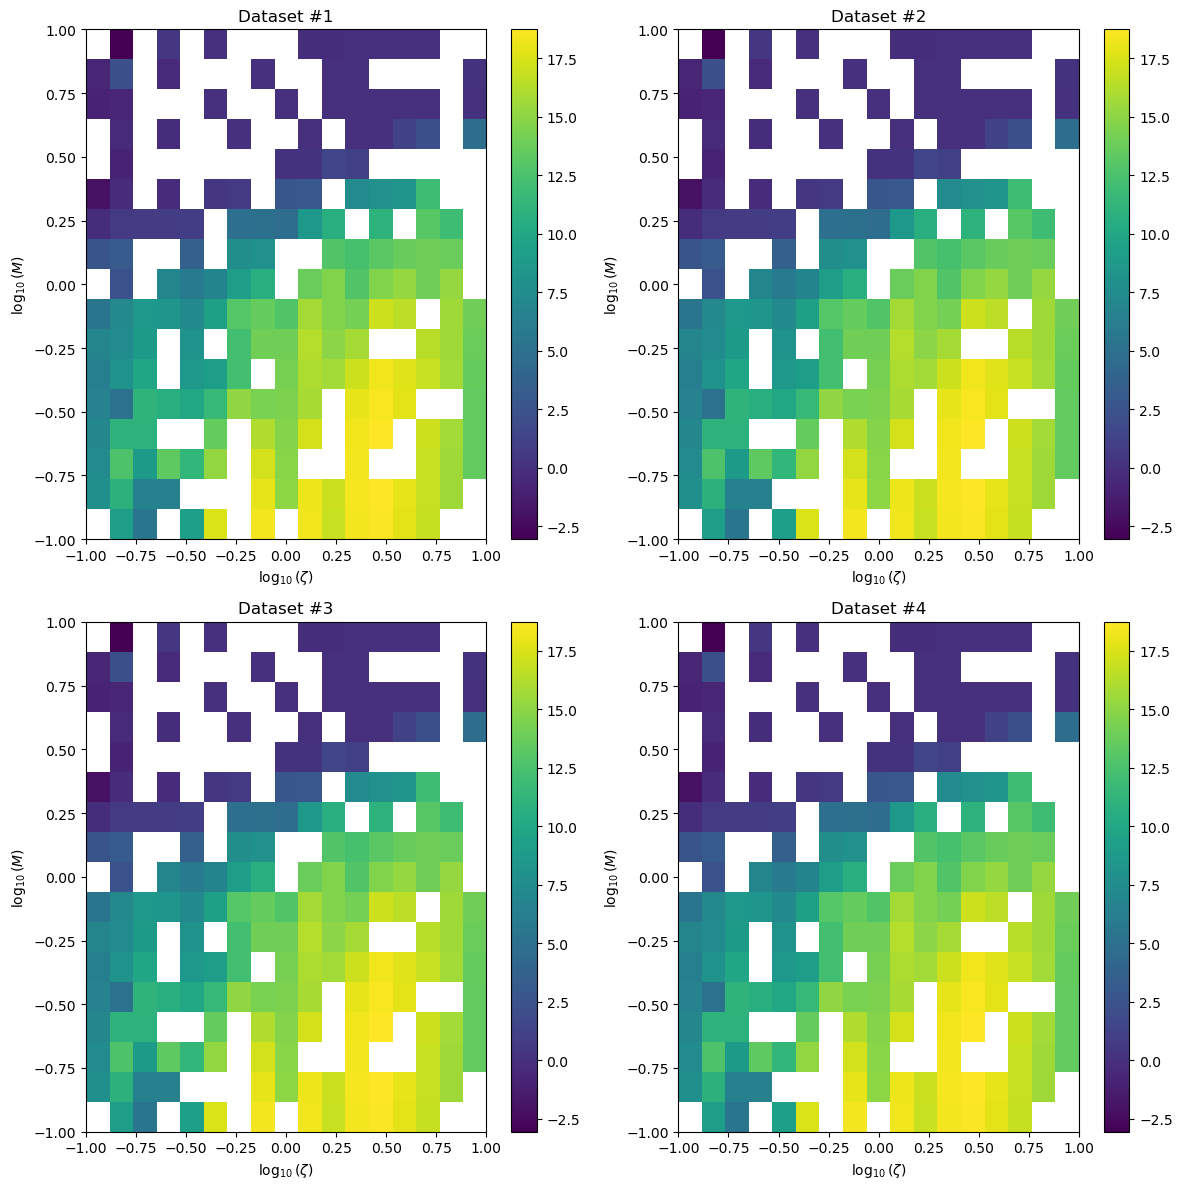

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def find_closest_index(raster, point):
    """
    Find the index of the value in the raster list closest to the given point.

    Args:
        raster (list): A list of numeric values (e.g., raster data).
        point (float): The target value to compare against.

    Returns:
        int: The index of the closest value in the raster list.
    """
    if not raster:
        raise ValueError("The raster list cannot be empty.")
    
    # Use min with a custom key to find the index of the closest value
    closest_index = min(range(len(raster)), key=lambda i: abs(raster[i] - point))
    return closest_index

# Create a figure for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten axes for easier indexing

# Loop through each dataset and create the subplots
for idx, r1data_kymax in enumerate(r1data_kymax_moreit):
    r1matrix_kymax_moreit = np.full((17, 17), np.NaN)
    zetas, ms, r1s = r1data_kymax
    for z, m, r1 in zip(zetas, ms, r1s):
        j = find_closest_index(zeta_range, z)
        i = 16 - find_closest_index(m_range, m)
        r1matrix_kymax_moreit[i, j] = np.log(r1)

    ax = axes[idx]
    im = ax.imshow(r1matrix_kymax_moreit, cmap='viridis', aspect='auto',extent=[-1, 1, -1, 1])
    fig.colorbar(im, ax=ax)
    ax.set_title(f'Dataset #{idx+1}')
    ax.set_xlabel(r'$\log_{10}(\zeta)$')
    ax.set_ylabel(r'$\log_{10}(M)$')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
# Hide any unused subplot axes
for ax in axes[4:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
fig.savefig("r1-kymax-convergence-incomplete.png")


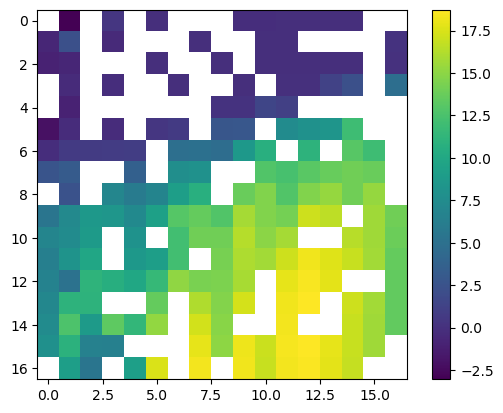

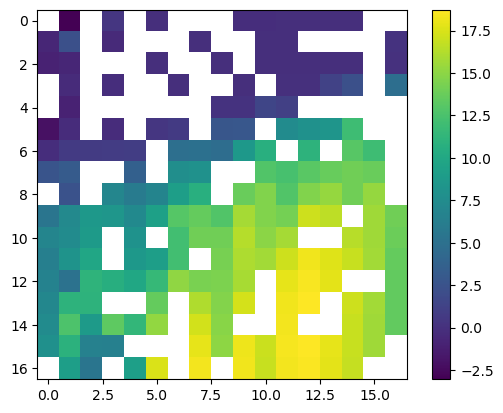

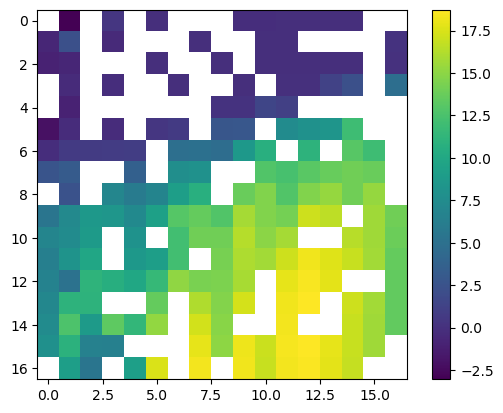

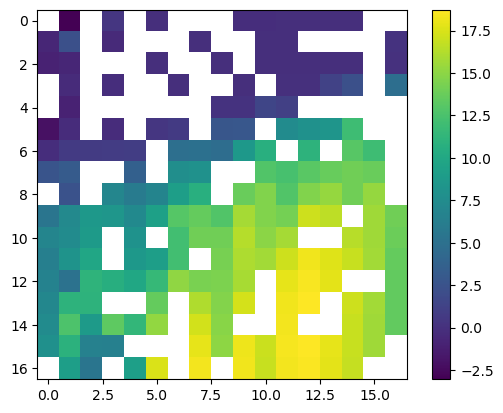

In [44]:
def find_closest_index(raster, point):
    """
    Find the index of the value in the raster list closest to the given point.

    Args:
        raster (list): A list of numeric values (e.g., raster data).
        point (float): The target value to compare against.

    Returns:
        int: The index of the closest value in the raster list.
    """
    if not raster:
        raise ValueError("The raster list cannot be empty.")
    
    # Use min with a custom key to find the index of the closest value
    closest_index = min(range(len(raster)), key=lambda i: abs(raster[i] - point))
    return closest_index

for r1data_kymax in r1data_kymax_moreit:
    r1matrix_kymax_moreit = np.full((17,17),np.NaN)
    zetas,ms,r1s = r1data_kymax
    for z,m,r1 in zip(zetas,ms,r1s):
        j = find_closest_index(zeta_range,z)
        i = 16-find_closest_index(m_range,m)
        r1matrix_kymax_moreit[i,j] = np.log(r1)

    plt.imshow(r1matrix_kymax_moreit)
    plt.colorbar()
    plt.show()

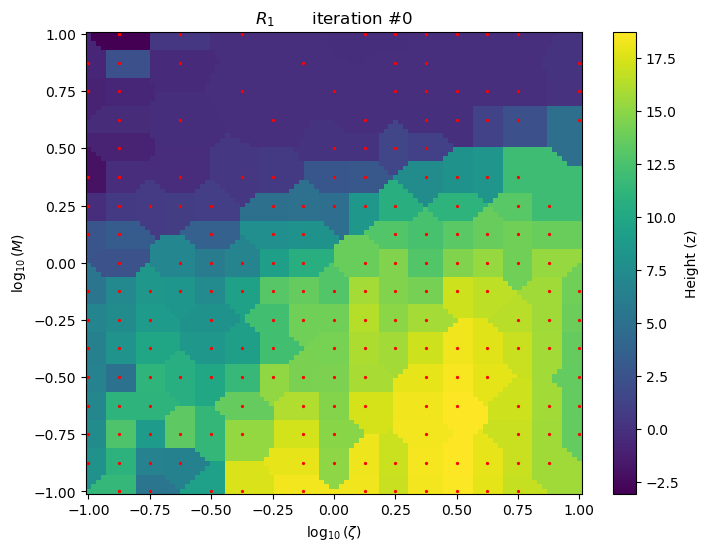

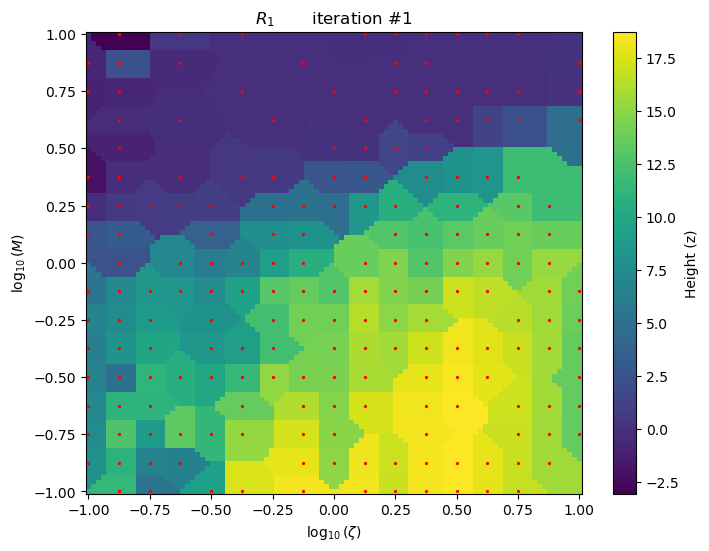

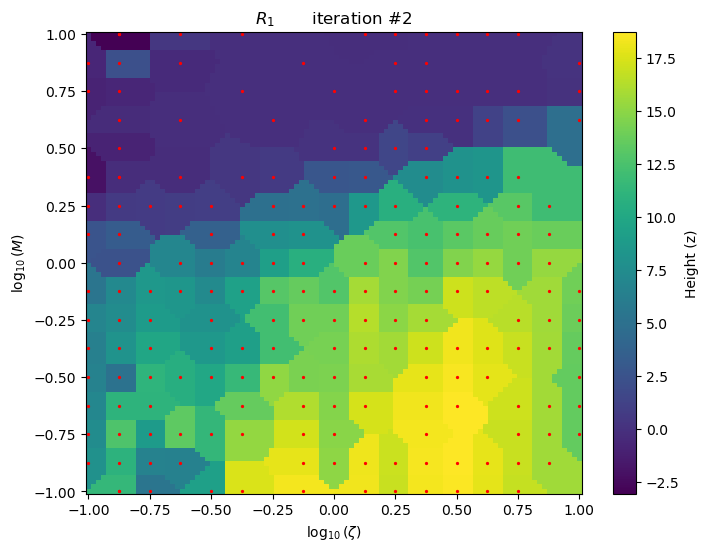

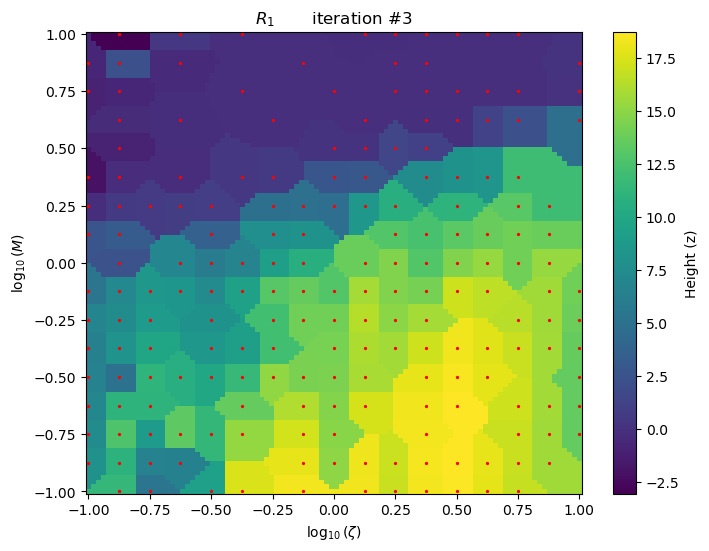

In [45]:
from scipy.interpolate import griddata

for i,dat in enumerate(r1data_kymax_moreit):
    
    zetas,ms,r1s = dat

    x = np.log10(zetas)
    y = np.log10(ms)
    z = np.log(r1s)

    # Define the grid for interpolation
    xi = np.linspace(np.min(x), np.max(x), 100)  # Create a regular grid in x
    yi = np.linspace(np.min(y), np.max(y), 100)  # Create a regular grid in y
    xi, yi = np.meshgrid(xi, yi)           # Create a 2D grid

    # Interpolate the z values onto the regular grid
    zi = griddata((x, y), z, (xi, yi), method='nearest')  # 'linear', 'nearest', or 'cubic'

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    heatmap = plt.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis')
    plt.colorbar(heatmap, label='Height (z)')
    plt.scatter(x, y, s=1.8, color='red', label='Data points')  # Optionally show the original points
    plt.xlabel(r'$\log_{10}(\zeta)$')
    plt.ylabel(r'$\log_{10}(M)$')
    # plt.legend()
    plt.title(r'$R_1$' + f"       iteration #{i}")
    plt.show()


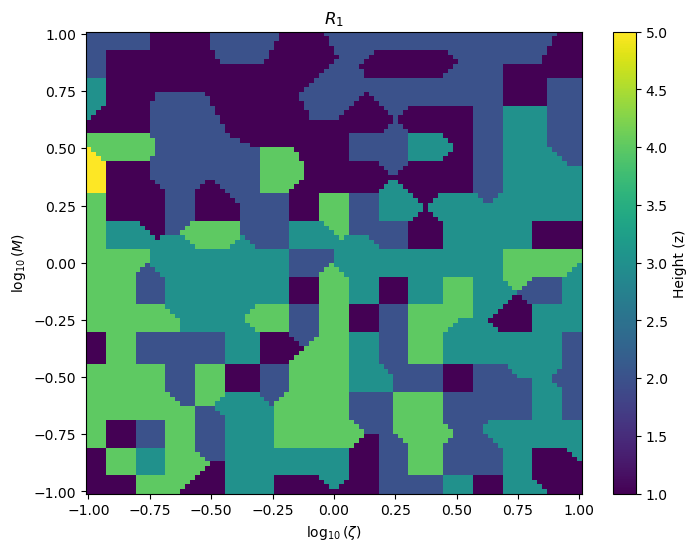

In [46]:
from scipy.interpolate import griddata

x = np.log10(zetas)
y = np.log10(ms)
z = [d["testresult"]["iterations"] for d in kydata]

# Define the grid for interpolation
xi = np.linspace(np.min(x), np.max(x), 100)  # Create a regular grid in x
yi = np.linspace(np.min(y), np.max(y), 100)  # Create a regular grid in y
xi, yi = np.meshgrid(xi, yi)           # Create a 2D grid

# Interpolate the z values onto the regular grid
zi = griddata((x, y), z, (xi, yi), method='nearest')  # 'linear', 'nearest', or 'cubic'

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis')
plt.colorbar(heatmap, label='Height (z)')
# plt.scatter(x, y, color='red', label='Data points')  # Optionally show the original points
plt.xlabel(r'$\log_{10}(\zeta)$')
plt.ylabel(r'$\log_{10}(M)$')
# plt.legend()
plt.title(r'$R_1$')
plt.show()


## Try to use builtin log scale

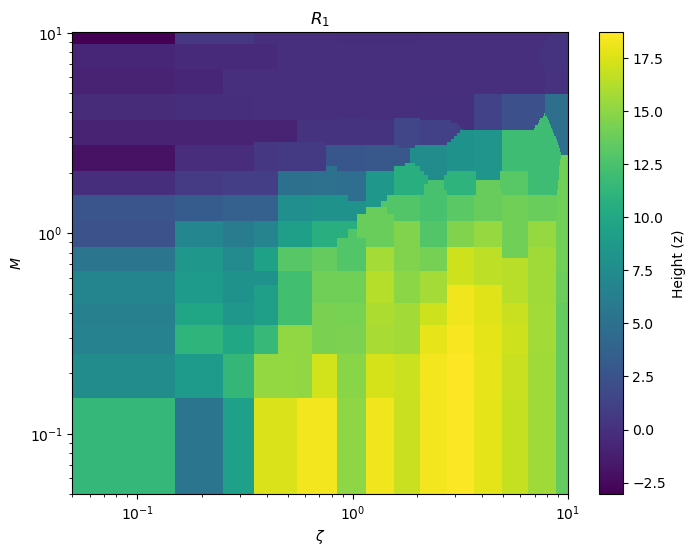

In [47]:
from scipy.interpolate import griddata

x = zetas
y = ms
z = np.log(r1s)

# Define the grid for interpolation
xi = np.linspace(np.min(x), np.max(x), 100)  # Create a regular grid in x
yi = np.linspace(np.min(y), np.max(y), 100)  # Create a regular grid in y
xi, yi = np.meshgrid(xi, yi)           # Create a 2D grid

# Interpolate the z values onto the regular grid
zi = griddata((x, y), z, (xi, yi), method='nearest')  # 'linear', 'nearest', or 'cubic'

# Plot the heatmap
plt.figure(figsize=(8, 6))
heatmap = plt.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis')
plt.colorbar(heatmap, label='Height (z)')
# plt.scatter(x, y, color='red', label='Data points')  # Optionally show the original points
plt.xlabel(r'$\zeta$')
plt.ylabel(r'$M$')
plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.title(r'$R_1$')
plt.show()
